# weather


✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Weather_all_groups_Spearman_NAaware_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Weather_all_groups_Spearman_NAaware_English.png



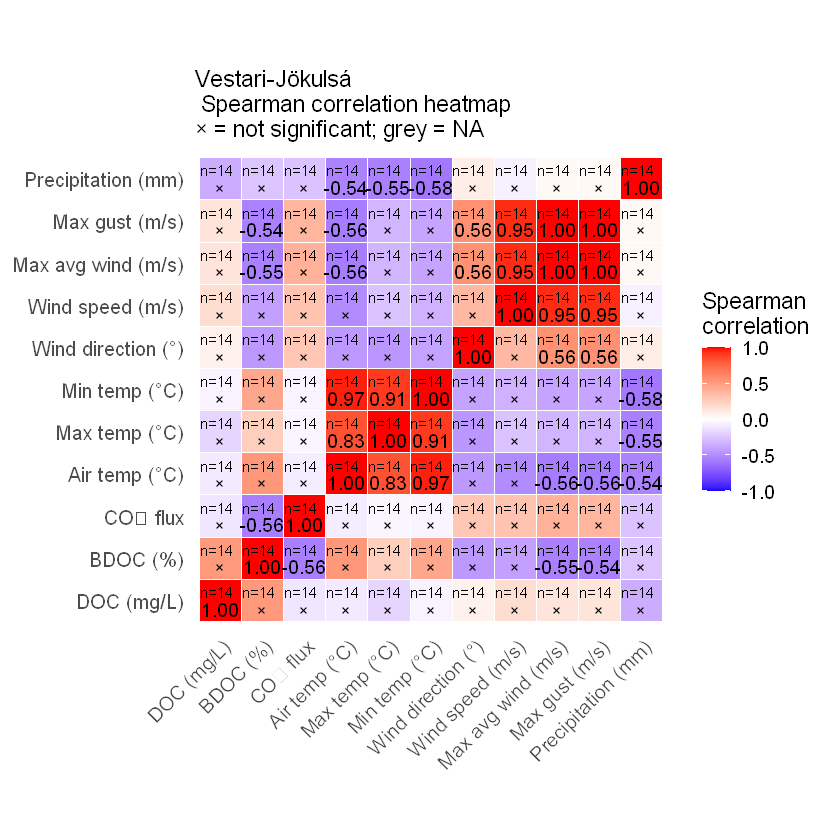

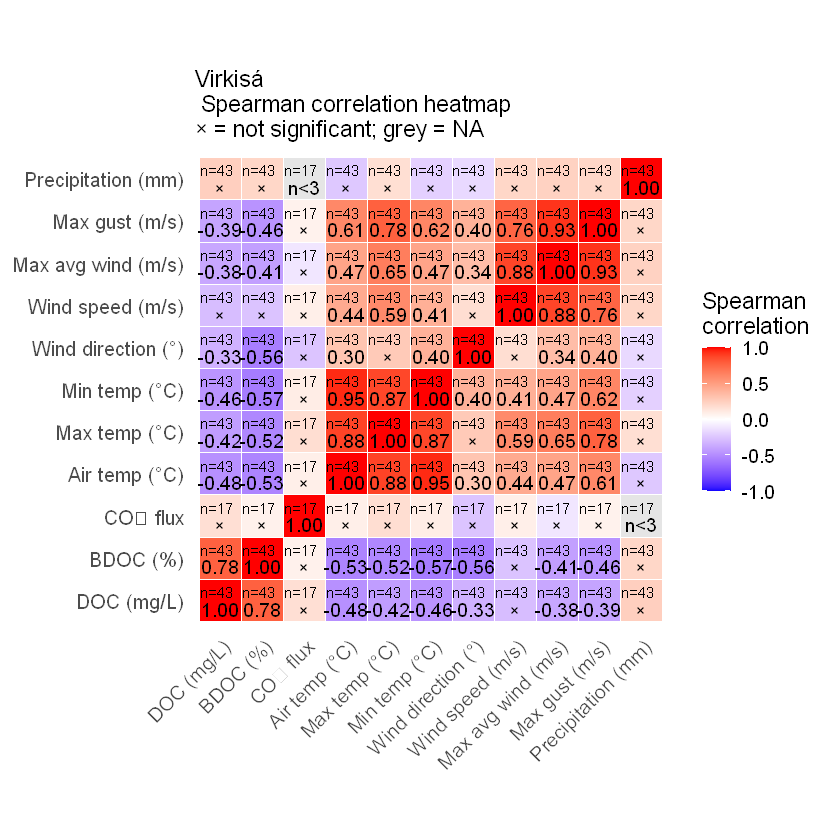

In [102]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
# Variablen & Labels
vars_keep <- c(
  "average_DOC_sample", "BDOC_pct", "CO2_Flux",
  "Air_temp", "Max_temp", "Min_temp",
  "Wind_direction_deg", "Wind_speed_mpers",
  "Max_av_wind_speed_mpers", "Max_wind_gust_mpers",
  "Precipitation_in_past_hour_mm"
)

rename_map <- c(
  average_DOC_sample            = "DOC (mg/L)",
  BDOC_pct                      = "BDOC (%)",
  CO2_Flux                      = "CO₂ flux",
  Air_temp                      = "Air temp (°C)",
  Max_temp                      = "Max temp (°C)",
  Min_temp                      = "Min temp (°C)",
  Wind_direction_deg            = "Wind direction (°)",
  Wind_speed_mpers              = "Wind speed (m/s)",
  Max_av_wind_speed_mpers       = "Max avg wind (m/s)",
  Max_wind_gust_mpers           = "Max gust (m/s)",
  Precipitation_in_past_hour_mm = "Precipitation (mm)"
)

# Korrelationstyp & Gruppenfilter
corr_type    <- "spearman"   # oder "spearman"
group_filter <- "all"       # "all" = alle Gruppen; 1 = nur group_nr==1; 2 = nur group_nr==2; etc.

# Plot-Feintuning (anpassbar)
label_size_main <- 4.0      # Größe der Hauptlabels (Werte/×/n<3)
label_fontface  <- "plain"  # "plain" oder "bold"
label_vjust     <- 1.05     # vertikale Lage der Hauptlabels (>1 = tiefer)
n_size          <- 3.2      # Größe der kleinen "n=..."-Labels
nudge_x         <- 0.38     # Position "n=..." rechts unten
nudge_y         <- 0.38
base_font_size  <- 14       # Grundschrift
axis_text_size  <- 12       # Achsentext
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# 🔎 Variablenuniversum
carbon_vars  <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")
weather_vars <- c("Air_temp","Max_temp","Min_temp",
                  "Wind_direction_deg","Wind_speed_mpers",
                  "Max_av_wind_speed_mpers","Max_wind_gust_mpers",
                  "Precipitation_in_past_hour_mm")
vars_all <- c(carbon_vars, weather_vars)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

# 🧰 Plot-Funktion (mit n-Overlay & NA-Handling)
make_plot <- function(river_id, pretty_title) {

  df_river <- df %>% filter(river_name == river_id)

  # nur existierende numerische Spalten
  df_sel0 <- df_river %>%
    select(any_of(vars_all)) %>%
    select(where(is.numeric))

  # Reihenfolge aus vars_keep respektieren
  keep_final <- intersect(vars_keep, names(df_sel0))
  df_sel <- if (length(keep_final) >= 2) df_sel0 %>% select(all_of(keep_final)) else df_sel0

  # Zeilen/Spalten filtern
  df_sel <- df_sel %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x) {
      v <- x[!is.na(x)]
      length(v) >= 3 && sd(v) != 0
    }))

  if (ncol(df_sel) < 2) stop("Not enough valid variables after filtering.")

  # 🔬 Correlation (rcorr liefert r, P, n)
  co <- rcorr(as.matrix(df_sel), type = corr_type)

  # >>> NEU: Diagonale klassisch auf 1 setzen <<<
  diag(co$r) <- 1

  # Wichtig: NA NICHT entfernen -> na.rm = FALSE
  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by = c("Var1","Var2")) %>%
    left_join(n_df, by = c("Var1","Var2"))
    # >>> ALT (entfernt): filter(Var1 != Var2)  — Diagonale soll sichtbar sein <<<

  # Labels mappen
  label_map <- setNames(names(df_sel), names(df_sel))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # >>> NEU: Diagonale zuerst beschriften (P ist dort NA)
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  # Achsenreihenfolge = Reihenfolge in df_sel (per Label)
  axis_order_lab <- unname(label_map[colnames(df_sel)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # 📊 Plot (mit einstellbarer Labelgröße/-position)
  leg_name    <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste0("group_nr=", group_filter))

  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    # Hauptlabel (Korrelation/×/n<3)
    geom_text(aes(label = Label),
              size = label_size_main, fontface = label_fontface, vjust = label_vjust) +
    # kleine n-Angabe unten rechts
    geom_text(aes(label = Nlab),
              size = n_size, hjust = 1.1, vjust = 1.1,
              nudge_x = nudge_x, nudge_y = nudge_y) +
    scale_fill_gradient2(
      low = "blue", mid = "white", high = "red", midpoint = 0,
      limits = c(-1, 1), name = leg_name, na.value = "grey90"
    ) +
    coord_fixed() +
    theme_minimal(base_size = base_font_size) +
    theme(
      axis.text.x = element_text(size = axis_text_size, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = axis_text_size),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = base_font_size, face = "plain")
    ) +
    labs(title = paste0(pretty_title, "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  # 💾 Save – Typ & Gruppe im Namen
  outfile <- file.path(
    out_dir,
    paste0("Heatmap_", river_id, "_Weather_",
           gsub("[ =]", "_", group_label), "_",
           toTitleCase(corr_type), "_NAaware_English.png")
  )
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)

  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Run for both rivers
make_plot("Vestari_Joekulsa", "Vestari-Jökulsá")
make_plot("Virkisa",         "Virkisá")


✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Weather_all_groups_Spearman_Stars_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Weather_all_groups_Spearman_Stars_English.png



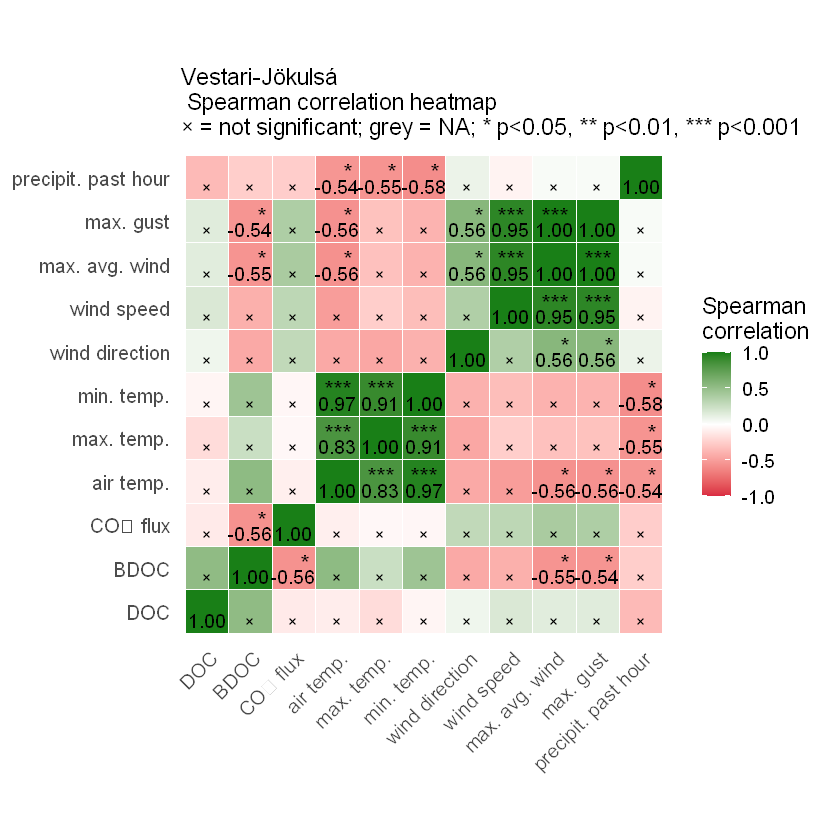

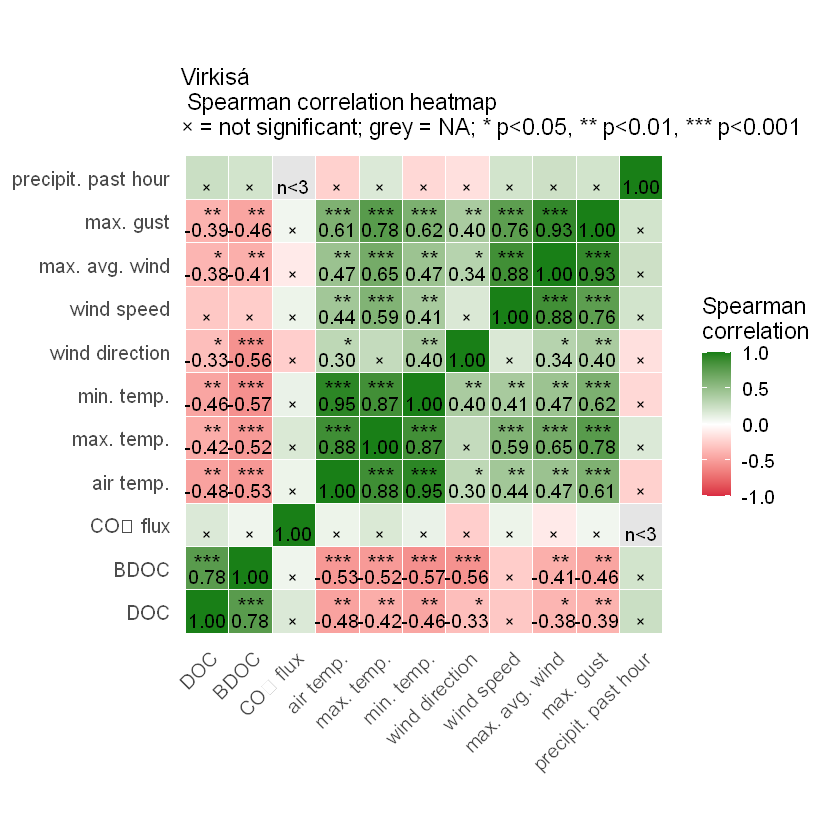

In [33]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
# Variablen & Labels
vars_keep <- c(
  "average_DOC_sample", "BDOC_pct", "CO2_Flux",
  "Air_temp", "Max_temp", "Min_temp",
  "Wind_direction_deg", "Wind_speed_mpers",
  "Max_av_wind_speed_mpers", "Max_wind_gust_mpers",
  "Precipitation_in_past_hour_mm"
)

rename_map <- c(
  average_DOC_sample            = "DOC",
  BDOC_pct                      = "BDOC",
  CO2_Flux                      = "CO₂ flux",
  Air_temp                      = "air temp.",
  Max_temp                      = "max. temp.",
  Min_temp                      = "min. temp.",
  Wind_direction_deg            = "wind direction",
  Wind_speed_mpers              = "wind speed",
  Max_av_wind_speed_mpers       = "max. avg. wind",
  Max_wind_gust_mpers           = "max. gust",
  Precipitation_in_past_hour_mm = "precipit. past hour"
)

# Korrelationstyp & Gruppenfilter
corr_type    <- "spearman"   # oder "pearson"
group_filter <- "all"        # "all" = alle Gruppen; 1 = nur group_nr==1; 2 = nur group_nr==2; etc.

# Plot-Feintuning (anpassbar)
label_size_main <- 4.0      # Größe Hauptlabel (Wert/×/n<3)
label_fontface  <- "plain"  # "plain" oder "bold"
label_vjust     <- 1.05     # vertikale Lage Hauptlabel
stars_size      <- 5      # 3.2 Größe der Sterne (statt n)
nudge_x         <- 0.38     # Position Sterne rechts unten
nudge_y         <- 0.38
base_font_size  <- 14
axis_text_size  <- 12

# Farben (türkis ↔ bordeaux)
col_low  <- "#d92941"
col_mid  <- "white"
col_high <- "#197f17"

# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# 🔎 Variablenuniversum
carbon_vars  <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")
weather_vars <- c("Air_temp","Max_temp","Min_temp",
                  "Wind_direction_deg","Wind_speed_mpers",
                  "Max_av_wind_speed_mpers","Max_wind_gust_mpers",
                  "Precipitation_in_past_hour_mm")
vars_all <- c(carbon_vars, weather_vars)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

# ⭐️ p -> Sterne
p_to_stars <- function(p) {
  ifelse(is.na(p), "",
    ifelse(p < 0.001, "***",
      ifelse(p < 0.01,  "**",
        ifelse(p < 0.05, "*", "")
      )
    )
  )
}

# 🧰 Plot-Funktion (mit Sterne-Overlay statt n)
make_plot <- function(river_id, pretty_title) {

  df_river <- df %>% filter(river_name == river_id)

  # nur existierende numerische Spalten
  df_sel0 <- df_river %>%
    select(any_of(vars_all)) %>%
    select(where(is.numeric))

  # Reihenfolge aus vars_keep respektieren
  keep_final <- intersect(vars_keep, names(df_sel0))
  df_sel <- if (length(keep_final) >= 2) df_sel0 %>% select(all_of(keep_final)) else df_sel0

  # Zeilen/Spalten filtern
  df_sel <- df_sel %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x) {
      v <- x[!is.na(x)]
      length(v) >= 3 && sd(v) != 0
    }))

  if (ncol(df_sel) < 2) stop("Not enough valid variables after filtering.")

  # 🔬 Correlation (rcorr liefert r, P, n)
  co <- rcorr(as.matrix(df_sel), type = corr_type)

  # Diagonale klassisch auf 1 setzen
  diag(co$r) <- 1

  # Wichtig: NA NICHT entfernen
  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by = c("Var1","Var2")) %>%
    left_join(n_df, by = c("Var1","Var2"))

  # Labels mappen
  label_map <- setNames(names(df_sel), names(df_sel))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # Hauptlabel: Wert / × / n<3
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      # ⭐︎ Sterne statt n:
      Stars = dplyr::case_when(
        is_diag | is.na(Correlation) ~ "",
        TRUE                         ~ p_to_stars(Pvalue)
      )
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  # Achsenreihenfolge = Reihenfolge in df_sel (per Label)
  axis_order_lab <- unname(label_map[colnames(df_sel)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # 📊 Plot
  leg_name    <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste0("group_nr=", group_filter))

  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    # Hauptlabel (Korrelation/×/n<3)
    geom_text(aes(label = Label),
              size = label_size_main, fontface = label_fontface, vjust = label_vjust) +
    # ⭐︎ Sterne unten rechts (ersetzen das frühere n-Label)
    geom_text(aes(label = Stars),
              size = stars_size, hjust = 1.1, vjust = 1.1,
              nudge_x = nudge_x, nudge_y = nudge_y) +
    scale_fill_gradient2(
      low = col_low, mid = col_mid, high = col_high, midpoint = 0,
      limits = c(-1, 1), name = leg_name, na.value = "grey90"
    ) +
    coord_fixed() +
    theme_minimal(base_size = base_font_size) +
    theme(
      axis.text.x = element_text(size = axis_text_size, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = axis_text_size),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = base_font_size, face = "plain")
    ) +
    labs(title = paste0(pretty_title, "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA; * p<0.05, ** p<0.01, *** p<0.001"))

  # 💾 Save
  outfile <- file.path(
    out_dir,
    paste0("Heatmap_", river_id, "_Weather_",
           gsub("[ =]", "_", group_label), "_",
           toTitleCase(corr_type), "_Stars_English.png")
  )
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)

  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Run for both rivers
make_plot("Vestari_Joekulsa", "Vestari-Jökulsá")
make_plot("Virkisa",         "Virkisá")


# environment 

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Env_all_groups_Spearman_NAaware_Signif_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Env_all_groups_Spearman_NAaware_Signif_English.png



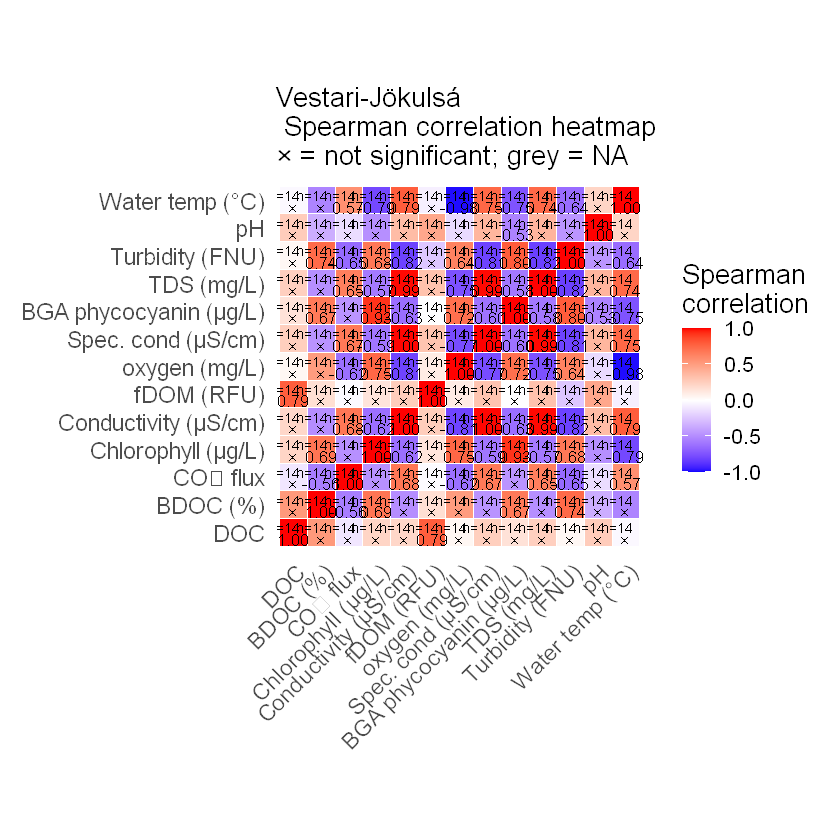

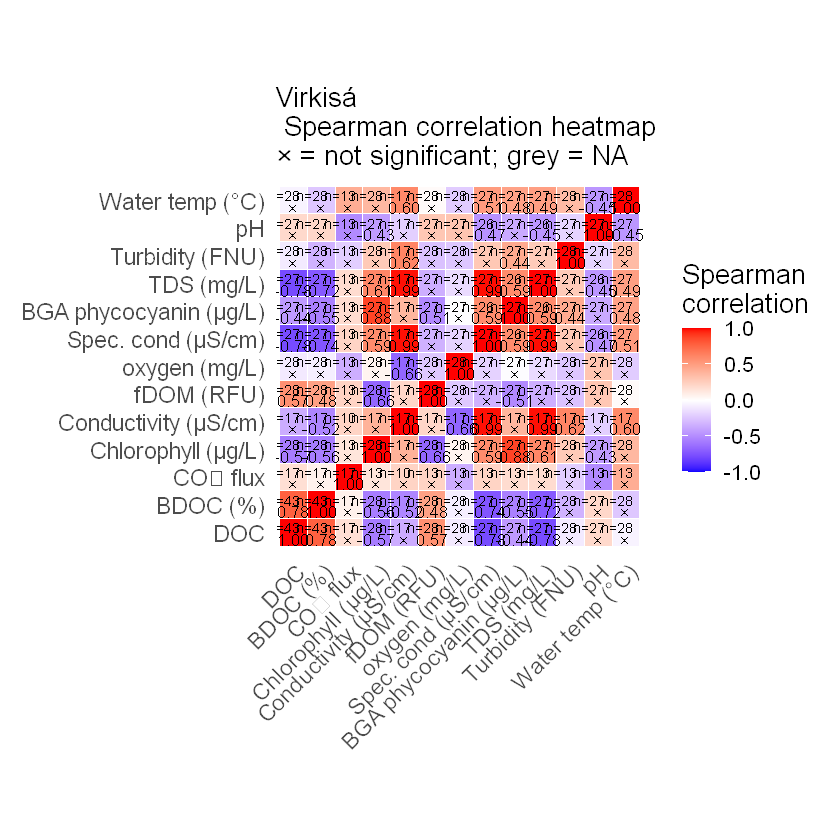

In [19]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type    <- "spearman"   # or "spearman"
group_filter <- "all"           # 1 = nur group_nr 1; "all" = alle; z.B. 2 = nur group_nr 2

# Carbon (fix)
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Environmental (dein Set)
env_vars <- c(
  "Chlorophyll_ugperL", "Cond_uSpercm_korr", "fDOM_RFU",
  "ODO_mgperL", "SpCond_uSpercm_korr", "BGA_PC_ugperL",
  "TDS_mgperL_korr", "Turbidity_FNU", "pH", "Temp_C"
)

# Achsenreihenfolge: erst Carbon, dann Environmental
vars_keep <- c(carbon_vars, env_vars)

# Englische Labels
rename_map <- c(
  average_DOC_sample       = "DOC",
  BDOC_pct                 = "BDOC (%)",
  CO2_Flux                 = "CO₂ flux",
  Chlorophyll_ugperL       = "Chlorophyll (µg/L)",
  Cond_uSpercm_korr        = "Conductivity (µS/cm)",
  fDOM_RFU                 = "fDOM (RFU)",
  ODO_mgperL               = "oxygen (mg/L)",
  SpCond_uSpercm_korr      = "Spec. cond (µS/cm)",
  BGA_PC_ugperL            = "BGA phycocyanin (µg/L)",
  TDS_mgperL_korr          = "TDS (mg/L)",
  Turbidity_FNU            = "Turbidity (FNU)",
  pH                       = "pH",
  Temp_C                   = "Water temp (°C)"
)

# Farben
col_low <- "blue"; col_mid <- "white"; col_high <- "red"
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 gewünschte Spalten zu numeric parsen (Komma → Punkt)
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

make_plot_env <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  # nur gewünschte Spalten, Reihenfolge respektieren
  d0 <- df_river %>% select(any_of(vars_keep))

  # Spalten mit n<3 oder sd==0 entfernen; Zeilen mit nur NAs raus
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)

  # >>> NEU: Diagonale klassisch auf 1 setzen <<<
  diag(co$r) <- 1

  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2"))
    # (Diagonale NICHT entfernen)

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # Diagonale zuerst behandeln (zeigt 1.00)
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name    <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste0("group_nr=", group_filter))

  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Label), size = 3.5, fontface = "plain", vjust = 1) +
    geom_text(aes(label = Nlab), size = 3,
              hjust = 1.1, vjust = 1, nudge_x = 0.38, nudge_y = 0.38) +
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(size = 14, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = 14),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = 16, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  outfile <- file.path(
    out_dir,
    paste0("Heatmap_", river_id, "_Env_", gsub("[ =]", "_", group_label), "_",
           toTitleCase(corr_type), "_NAaware_Signif_English.png")
  )
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_env("Vestari_Joekulsa")
make_plot_env("Virkisa")


✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Env_all_groups_Spearman_Stars_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Env_all_groups_Spearman_Stars_English.png



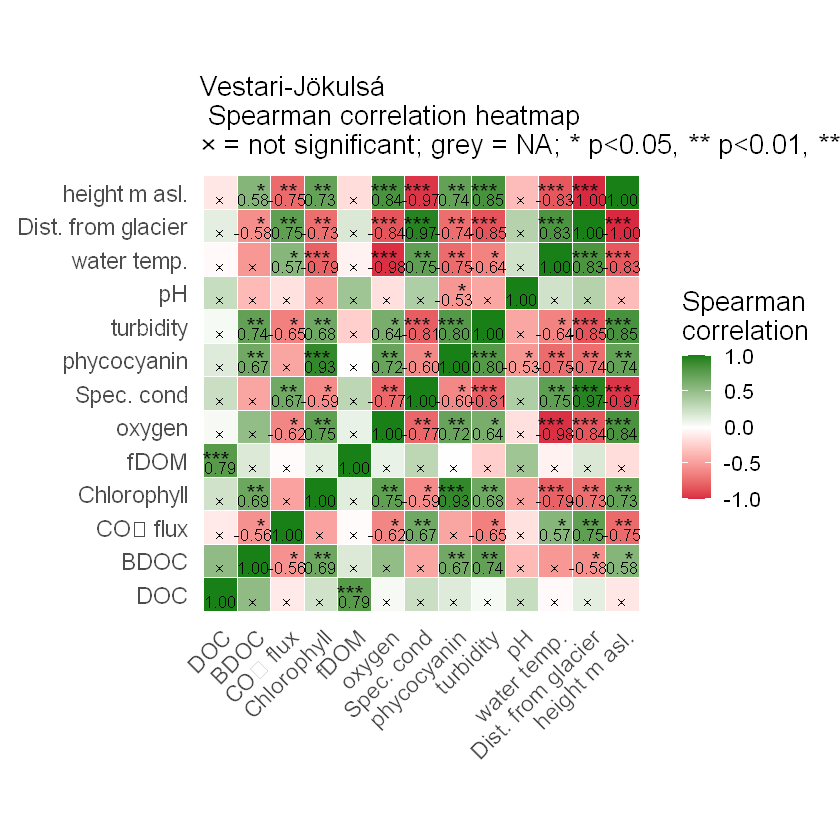

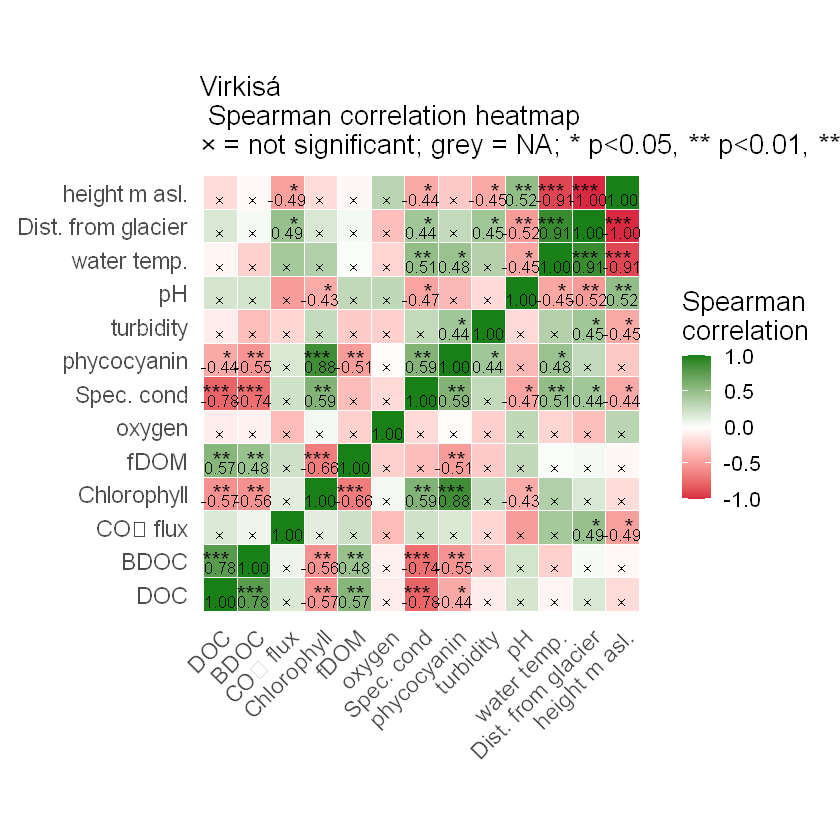

In [32]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type    <- "spearman"   # oder "pearson"
group_filter <- "all"        # "all" = alle; 1 = nur group_nr==1; 2 = nur group_nr==2; ...

# Carbon
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Environmental
env_vars <- c(
  "Chlorophyll_ugperL",  "fDOM_RFU",
  "ODO_mgperL", "SpCond_uSpercm_korr", "BGA_PC_ugperL",
   "Turbidity_FNU", "pH", "Temp_C","distance_from_glacier","Hight_sl"

)

# Achsenreihenfolge
vars_keep <- c(carbon_vars, env_vars)

# Labels
rename_map <- c(
  average_DOC_sample  = "DOC",
  BDOC_pct            = "BDOC",
  CO2_Flux            = "CO₂ flux",
  Chlorophyll_ugperL  = "Chlorophyll",
  fDOM_RFU            = "fDOM",
  ODO_mgperL          = "oxygen",
  SpCond_uSpercm_korr = "Spec. cond",
  BGA_PC_ugperL       = "phycocyanin",
  Turbidity_FNU       = "turbidity",
  pH                  = "pH",
  Temp_C              = "water temp.",
  distance_from_glacier = "Dist. from glacier",
 Hight_sl = "height m asl." 

)

# Farben (Türkis ↔ Bordeaux)
col_low  <- "#d92941"; col_mid <- "white"; col_high <- "#197f17"
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 numerisch parsen (Komma -> Punkt)
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

# ⭐️ p -> Sterne
p_to_stars <- function(p) {
  ifelse(is.na(p), "",
    ifelse(p < 0.001, "***",
      ifelse(p < 0.01,  "**",
        ifelse(p < 0.05, "*", "")
      )
    )
  )
}

make_plot_env <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  d0 <- df_river %>% select(any_of(vars_keep))
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)

  # Diagonale = 1
  diag(co$r) <- 1

  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2"))

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # Hauptlabel: Wert / × / n<3
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      # ⭐︎ Sterne (statt n)
      Stars = dplyr::case_when(
        is_diag | is.na(Correlation) ~ "",
        TRUE                         ~ p_to_stars(Pvalue)
      )
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name    <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste0("group_nr=", group_filter))

  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Label), size = 3.5, fontface = "plain", vjust = 1) +
    geom_text(aes(label = Stars), size = 5,
              hjust = 1.1, vjust = 1.2, nudge_x = 0.36, nudge_y = 0.40) +
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(size = 14, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = 14),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = 16, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA; * p<0.05, ** p<0.01, *** p<0.001"))

  outfile <- file.path(
    out_dir,
    paste0("Heatmap_", river_id, "_Env_", gsub("[ =]", "_", group_label), "_",
           toTitleCase(corr_type), "_Stars_English.png")
  )
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_env("Vestari_Joekulsa")
make_plot_env("Virkisa")


# fluo

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Fluo_all_groups_Spearman_NAaware_Signif_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Fluo_all_groups_Spearman_NAaware_Signif_English.png



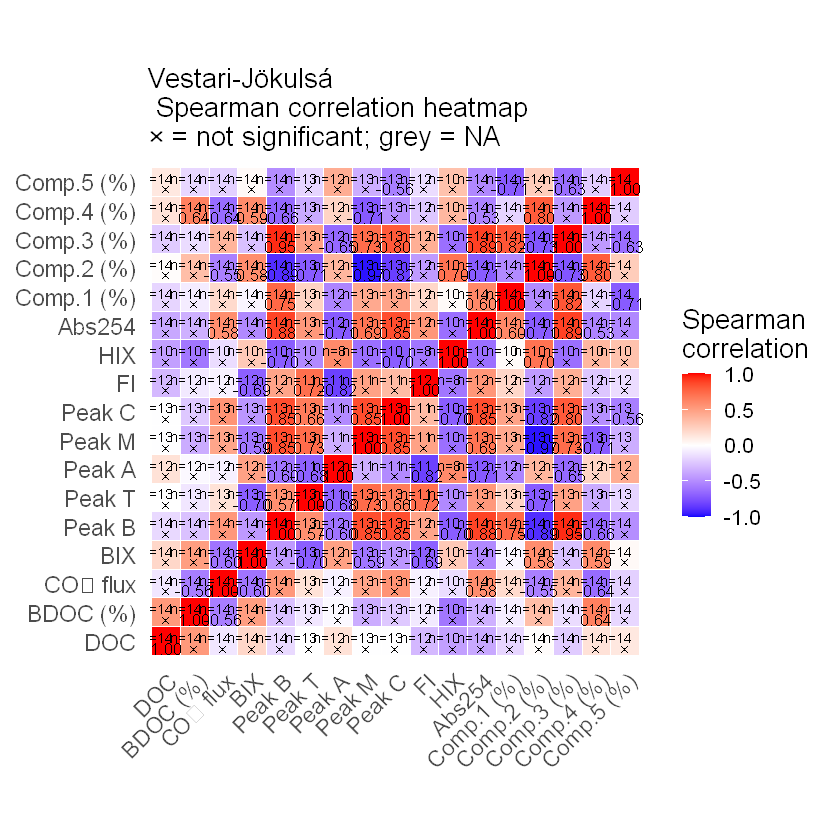

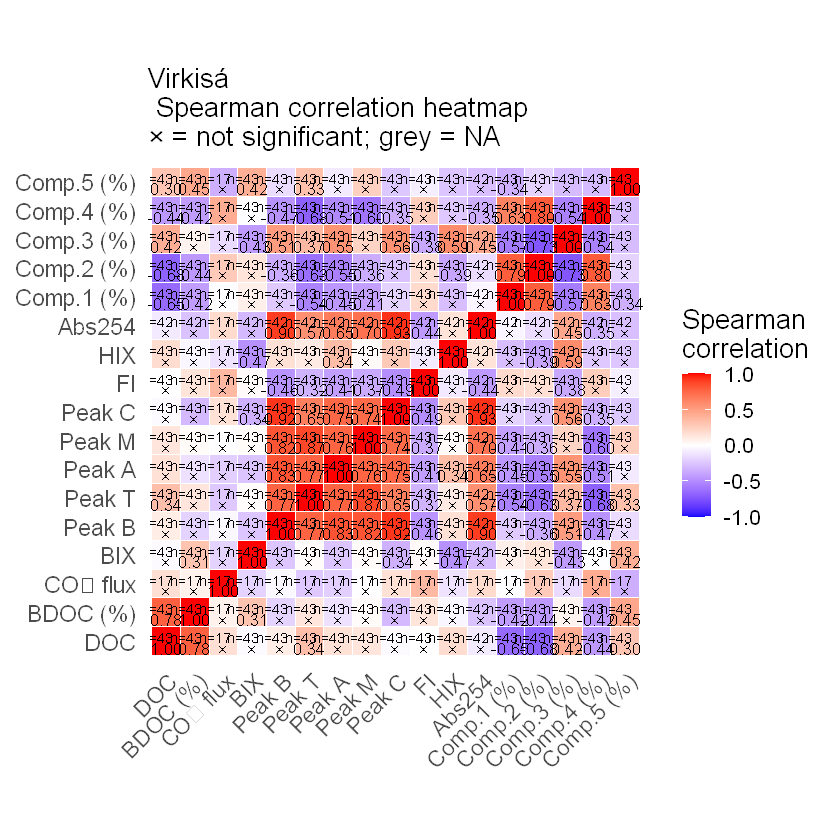

In [25]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type   <- "spearman"    # or "spearman"
group_filter <- "all"           # 1 = nur group_nr 1; "all" = alle Gruppen; z.B. 2 = nur group_nr 2

# Carbon (fix)
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Fluorescence (dein Set)
fluo_vars <- c(
  "bix", "b", "t", "a", "m", "c", "fi", "hix", "a254",
  "pctComp.1", "pctComp.2", "pctComp.3", "pctComp.4", "pctComp.5"
)

# Achsen: erst Carbon, dann Fluorescence
vars_keep <- c(carbon_vars, fluo_vars)

# Labels
rename_map <- c(
  average_DOC_sample = "DOC",
  BDOC_pct           = "BDOC (%)",
  CO2_Flux           = "CO₂ flux",
  bix                = "BIX",
  b                  = "Peak B",
  t                  = "Peak T",
  a                  = "Peak A",
  m                  = "Peak M",
  c                  = "Peak C",
  fi                 = "FI",
  hix                = "HIX",
  a254               = "Abs254",
  pctComp.1          = "Comp.1 (%)",
  pctComp.2          = "Comp.2 (%)",
  pctComp.3          = "Comp.3 (%)",
  pctComp.4          = "Comp.4 (%)",
  pctComp.5          = "Comp.5 (%)"
)

col_low  <- "blue"; col_mid  <- "white"; col_high <- "red"
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 gewünschte Spalten numerisch parsen
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

make_plot_fluo <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  d0 <- df_river %>% select(any_of(vars_keep))
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)

  # >>> NEU: Diagonale klassisch auf 1 setzen <<<
  diag(co$r) <- 1

  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2"))
    # (Diagonale NICHT entfernen)

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # Diagonale zuerst behandeln (zeigt 1.00)
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste("group_nr=", group_filter))
  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Label), size = 3.5, fontface = "plain", vjust = 1) +
    geom_text(aes(label = Nlab), size = 3,
          hjust = 1.1, vjust = 1.3, nudge_x = 0.38, nudge_y = 0.45) +
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(size = 14, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = 14),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = 16, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  outfile <- file.path(out_dir, paste0("Heatmap_", river_id, "_Fluo_", group_label, "_",
                                       toTitleCase(corr_type), "_NAaware_Signif_English.png"))
  # Leerzeichen und = im Dateinamen durch _ ersetzen
  outfile <- gsub("[ =]", "_", outfile)
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_fluo("Vestari_Joekulsa")
make_plot_fluo("Virkisa")


✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Fluo_all_groups_Spearman_Stars_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Fluo_all_groups_Spearman_Stars_English.png



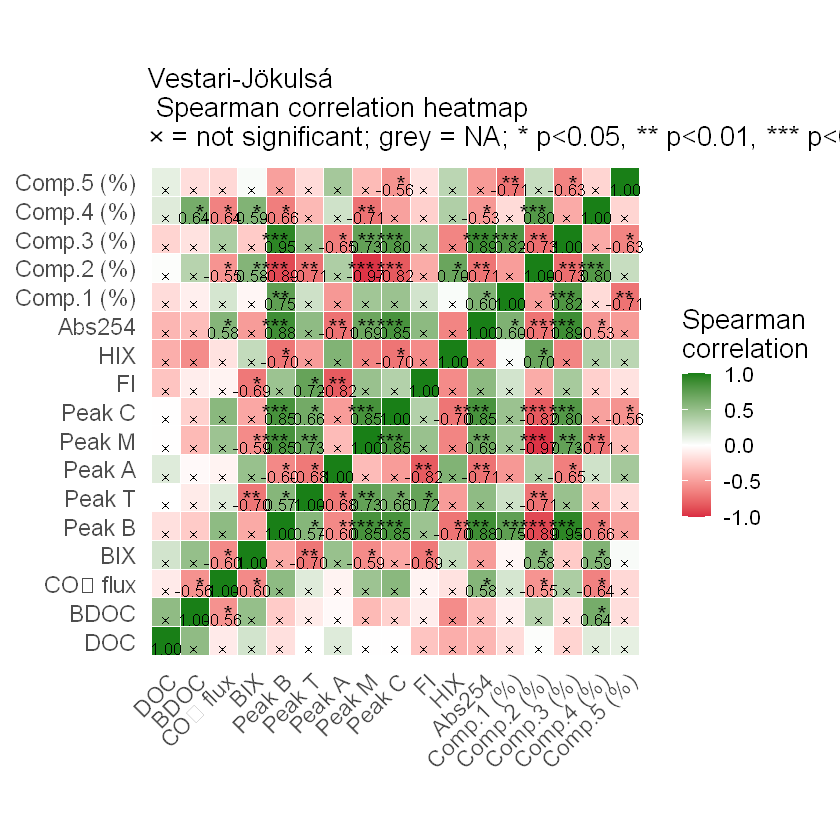

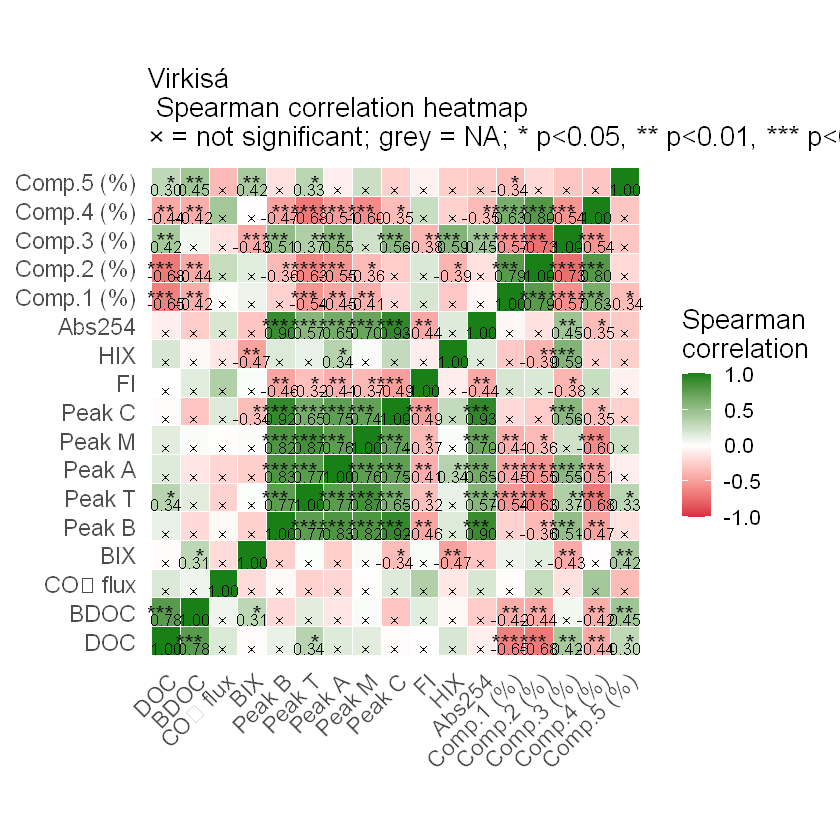

In [31]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type    <- "spearman"        # oder "pearson"
group_filter <- "all"             # "all" = alle Gruppen; 1 = nur group_nr==1; ...

# Carbon (fix)
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Fluorescence (dein Set)
fluo_vars <- c(
  "bix", "b", "t", "a", "m", "c", "fi", "hix", "a254",
  "pctComp.1", "pctComp.2", "pctComp.3", "pctComp.4", "pctComp.5"
)

# Achsen: erst Carbon, dann Fluorescence
vars_keep <- c(carbon_vars, fluo_vars)

# Labels
rename_map <- c(
  average_DOC_sample = "DOC",
  BDOC_pct           = "BDOC",
  CO2_Flux           = "CO₂ flux",
  bix                = "BIX",
  b                  = "Peak B",
  t                  = "Peak T",
  a                  = "Peak A",
  m                  = "Peak M",
  c                  = "Peak C",
  fi                 = "FI",
  hix                = "HIX",
  a254               = "Abs254",
  pctComp.1          = "Comp.1 (%)",
  pctComp.2          = "Comp.2 (%)",
  pctComp.3          = "Comp.3 (%)",
  pctComp.4          = "Comp.4 (%)",
  pctComp.5          = "Comp.5 (%)"
)

# Farben (türkis ↔ bordeaux)
col_low  <- "#d92941"
col_mid  <- "white"
col_high <- "#197f17"

# Textgrößen/Feintuning
label_size_main <- 3.5
stars_size      <- 5
base_font_size  <- 16
axis_text_size  <- 14
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 gewünschte Spalten numerisch parsen
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

# ⭐️ p -> Sterne
p_to_stars <- function(p) {
  ifelse(is.na(p), "",
    ifelse(p < 0.001, "***",
      ifelse(p < 0.01,  "**",
        ifelse(p < 0.05, "*", "")
      )
    )
  )
}

make_plot_fluo <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  d0 <- df_river %>% select(any_of(vars_keep))
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)

  # Diagonale klassisch auf 1 setzen
  diag(co$r) <- 1

  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2"))

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # Hauptlabel: Wert / × / n<3 (Diagonale zeigt 1.00)
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      # ⭐︎ Sterne (statt n)
      Stars = dplyr::case_when(
        is_diag | is.na(Correlation) ~ "",
        TRUE                         ~ p_to_stars(Pvalue)
      )
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste("group_nr=", group_filter))
  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Label), size = label_size_main, fontface = "plain", vjust = 1.02) +
    geom_text(aes(label = Stars), size = stars_size, hjust = 1.1, vjust = 1.25, nudge_x = 0.36, nudge_y = 0.42) +
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = base_font_size) +
    theme(
      axis.text.x = element_text(size = axis_text_size, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = axis_text_size),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = base_font_size, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA; * p<0.05, ** p<0.01, *** p<0.001"))

  outfile <- file.path(out_dir, paste0("Heatmap_", river_id, "_Fluo_", group_label, "_",
                                       toTitleCase(corr_type), "_Stars_English.png"))
  outfile <- gsub("[ =]", "_", outfile)
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_fluo("Vestari_Joekulsa")
make_plot_fluo("Virkisa")


# Table


In [89]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr)
  library(purrr);  library(tibble); library(openxlsx)
  library(knitr)
})

# ==== Paths ====
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
in_file  <- file.path(base_dir, "Sophia_Data.xls")
out_dir  <- file.path(base_dir, "Ergebnisse_HM_Wetter", "Tabellen")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Load data ====
dat <- read_excel(in_file)

# ==== Variable groups ====
carbon_vars <- c(
  "average_DOC_sample" = "DOC (mg/L)",
  "BDOC_pct"           = "BDOC (%)",
  "CO2_Flux"           = "CO₂ flux"
)

weather_vars <- c(
  "Air_temp"                    = "Air temp (°C)",
  "Max_temp"                    = "Max temp (°C)",
  "Min_temp"                    = "Min temp (°C)",
  "Wind_direction_deg"          = "Wind direction (°)",
  "Wind_speed_mpers"            = "Wind speed (m/s)",
  "Max_av_wind_speed_mpers"     = "Max avg wind (m/s)",
  "Max_wind_gust_mpers"         = "Max gust (m/s)",
  "Precipitation_in_past_hour_mm" = "Precipitation (mm)"
)

env_vars <- c(
  "Chlorophyll_ugperL"   = "Chlorophyll (µg/L)",
  "Cond_uSpercm_korr"    = "Conductivity (µS/cm)",
  "fDOM_RFU"             = "fDOM (RFU)",
  "ODO_mgperL"           = "Dissolved O₂ (mg/L)",
  "SpCond_uSpercm_korr"  = "Specific Conductivity (µS/cm)",
  "BGA_PC_ugperL"        = "Phycocyanin (µg/L)",
  "TDS_mgperL_korr"      = "TDS (mg/L)",
  "Turbidity_FNU"        = "Turbidity (FNU)",
  "pH"                   = "pH (-)",
  "Temp_C"               = "Water temp (°C)"
)

fluo_vars <- c(
  "bix"       = "BIX",
  "b"         = "PARAFAC b",
  "t"         = "PARAFAC t",
  "a"         = "PARAFAC a",
  "m"         = "PARAFAC m",
  "c"         = "PARAFAC c",
  "fi"        = "FI",
  "hix"       = "HIX",
  "a254"      = "Absorbance at 254 nm",
  "pctComp.1" = "Component 1 (%)",
  "pctComp.2" = "Component 2 (%)",
  "pctComp.3" = "Component 3 (%)",
  "pctComp.4" = "Component 4 (%)",
  "pctComp.5" = "Component 5 (%)"
)

# ==== Safe numeric conversion ====
as_numeric_safely <- function(x) {
  if (is.numeric(x)) return(x)
  if (is.factor(x))  x <- as.character(x)
  if (is.character(x)) {
    x <- trimws(x)
    x <- gsub("\\.", "", x)              # remove thousands separator
    x <- gsub(",", ".", x, fixed = TRUE) # convert , to .
  }
  suppressWarnings(as.numeric(x))
}

# ==== Shapiro & correlation choice ====
one_var_stats <- function(vec) {
  x <- vec[!is.na(vec)]
  n <- length(x)
  if (n >= 3 && n <= 5000) {
    sh <- try(shapiro.test(x), silent = TRUE)
    if (inherits(sh, "try-error")) {
      list(n = n, W = NA_real_, p = NA_real_, normal = "error", test = "not available")
    } else {
      pval <- sh$p.value
      normal <- ifelse(pval > 0.05, "yes", "no")
      test   <- ifelse(pval > 0.05, "Pearson", "Spearman")
      list(n = n, W = unname(sh$statistic), p = pval, normal = normal, test = test)
    }
  } else if (n > 5000) {
    list(n = n, W = NA_real_, p = NA_real_, normal = "n > 5000 (Shapiro not valid)", test = "Pearson (large n)")
  } else {
    list(n = n, W = NA_real_, p = NA_real_, normal = "too few data", test = "not available")
  }
}

make_table <- function(df, named_vars) {
  map_dfr(names(named_vars), function(v) {
    x_raw <- df[[v]]
    x_num <- as_numeric_safely(x_raw)
    stats <- one_var_stats(x_num)
    tibble(
      Variable          = v,
      Label             = unname(named_vars[v]),
      n_obs             = stats$n,
      Shapiro_W         = if (!is.na(stats$W)) round(stats$W, 3) else NA_real_,
      Shapiro_p         = if (!is.na(stats$p)) signif(stats$p, 3) else NA_real_,
      Normality         = stats$normal,
      Suggested_test    = stats$test
    )
  })
}

# ==== Create tables ====
tab_carbon  <- make_table(dat, carbon_vars)
tab_weather <- make_table(dat, weather_vars)
tab_env     <- make_table(dat, env_vars)
tab_fluo    <- make_table(dat, fluo_vars)

# ==== Show nicely in Jupyter (ASCII tables, no HTML) ====
cat("\n=== CARBON ===\n")
print(kable(tab_carbon, format = "simple"))

cat("\n=== WEATHER ===\n")
print(kable(tab_weather, format = "simple"))

cat("\n=== ENVIRONMENT ===\n")
print(kable(tab_env, format = "simple"))

cat("\n=== FLUORESCENCE ===\n")
print(kable(tab_fluo, format = "simple"))

# ==== Save as Excel ====
write.xlsx(tab_carbon,  file.path(out_dir, "Carbon_Table.xlsx"))
write.xlsx(tab_weather, file.path(out_dir, "Weather_Table.xlsx"))
write.xlsx(tab_env,     file.path(out_dir, "Environment_Table.xlsx"))
write.xlsx(tab_fluo,    file.path(out_dir, "Fluo_Table.xlsx"))



=== CARBON ===


Variable             Label         n_obs   Shapiro_W   Shapiro_p  Normality   Suggested_test 
-------------------  -----------  ------  ----------  ----------  ----------  ---------------
average_DOC_sample   DOC (mg/L)       57       0.868    1.63e-05  no          Spearman       
BDOC_pct             BDOC (%)         57       0.963    7.72e-02  yes         Pearson        
CO2_Flux             CO₂ flux         31       0.902    7.99e-03  no          Spearman       

=== WEATHER ===


Variable                        Label                 n_obs   Shapiro_W   Shapiro_p  Normality   Suggested_test 
------------------------------  -------------------  ------  ----------  ----------  ----------  ---------------
Air_temp                        Air temp (°C)            57       0.963    7.64e-02  yes         Pearson        
Max_temp                        Max temp (°C)            57       0.964    8.64e-02  yes         Pearson        
Min_temp                        Min temp 

Warning message in file.create(to[okay]):
"kann Datei 'C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Tabellen/Environment_Table.xlsx' nicht erzeugen. Grund 'Permission denied'"
Warning message in file.create(to[okay]):
"kann Datei 'C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Tabellen/Fluo_Table.xlsx' nicht erzeugen. Grund 'Permission denied'"


In [1]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr)
  library(purrr);  library(tibble); library(openxlsx)
  library(knitr)
})

# ==== Paths ====
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
in_file  <- file.path(base_dir, "Sophia_Data.xls")
out_dir  <- file.path(base_dir, "Ergebnisse_HM_Wetter", "Tabellen")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Load data ====
dat <- read_excel(in_file)

# ==== Variable groups ====
carbon_vars <- c(
  "average_DOC_sample" = "DOC (mg/L)",
  "BDOC_pct"           = "BDOC (%)",
  "CO2_Flux"           = "CO₂ flux"
)

weather_vars <- c(
  "Air_temp"                      = "Air temp (°C)",
  "Max_temp"                      = "Max temp (°C)",
  "Min_temp"                      = "Min temp (°C)",
  "Wind_direction_deg"            = "Wind direction (°)",
  "Wind_speed_mpers"              = "Wind speed (m/s)",
  "Max_av_wind_speed_mpers"       = "Max avg wind (m/s)",
  "Max_wind_gust_mpers"           = "Max gust (m/s)",
  "Precipitation_in_past_hour_mm" = "Precipitation (mm)"
)

env_vars <- c(
  "Chlorophyll_ugperL"  = "Chlorophyll (µg/L)",
  "Cond_uSpercm_korr"   = "Conductivity (µS/cm)",
  "fDOM_RFU"            = "fDOM (RFU)",
  "ODO_mgperL"          = "Dissolved O₂ (mg/L)",
  "SpCond_uSpercm_korr" = "Specific Conductivity (µS/cm)",
  "BGA_PC_ugperL"       = "Phycocyanin (µg/L)",
  "TDS_mgperL_korr"     = "TDS (mg/L)",
  "Turbidity_FNU"       = "Turbidity (FNU)",
  "pH"                  = "pH (-)",
  "Temp_C"              = "Water temp (°C)"
)

fluo_vars <- c(
  "bix"       = "BIX",
  "b"         = "PARAFAC b",
  "t"         = "PARAFAC t",
  "a"         = "PARAFAC a",
  "m"         = "PARAFAC m",
  "c"         = "PARAFAC c",
  "fi"        = "FI",
  "hix"       = "HIX",
  "a254"      = "Absorbance at 254 nm",
  "pctComp.1" = "Component 1 (%)",
  "pctComp.2" = "Component 2 (%)",
  "pctComp.3" = "Component 3 (%)",
  "pctComp.4" = "Component 4 (%)",
  "pctComp.5" = "Component 5 (%)"
)

# ==== Safe numeric conversion ====
as_numeric_safely <- function(x) {
  if (is.numeric(x)) return(x)
  if (is.factor(x))  x <- as.character(x)
  if (is.character(x)) {
    x <- trimws(x)
    x <- gsub("\\.", "", x)              # Tausenderpunkt entfernen
    x <- gsub(",", ".", x, fixed = TRUE) # Komma -> Punkt
  }
  suppressWarnings(as.numeric(x))
}

# ==== Shapiro & correlation choice ====
one_var_stats <- function(vec) {
  x <- vec[!is.na(vec)]
  n <- length(x)
  if (n >= 3 && n <= 5000) {
    sh <- try(shapiro.test(x), silent = TRUE)
    if (inherits(sh, "try-error")) {
      list(n = n, W = NA_real_, p = NA_real_, normal = "error", test = "not available")
    } else {
      pval <- sh$p.value
      normal <- ifelse(pval > 0.05, "yes", "no")
      test   <- ifelse(pval > 0.05, "Pearson", "Spearman")
      list(n = n, W = unname(sh$statistic), p = pval, normal = normal, test = test)
    }
  } else if (n > 5000) {
    list(n = n, W = NA_real_, p = NA_real_, normal = "n > 5000 (Shapiro not valid)", test = "Pearson (large n)")
  } else {
    list(n = n, W = NA_real_, p = NA_real_, normal = "too few data", test = "not available")
  }
}

# ==== Table builder (mit Significance-Spalte) ====
make_table <- function(df, named_vars) {
  purrr::map_dfr(names(named_vars), function(v) {
    x_raw <- df[[v]]
    x_num <- as_numeric_safely(x_raw)
    stats <- one_var_stats(x_num)

    signif_code <- ifelse(is.na(stats$p), "",
                     ifelse(stats$p < 0.001, "***",
                     ifelse(stats$p < 0.01,  "**",
                     ifelse(stats$p < 0.05,  "*", "ns"))))

    tibble(
      Variable       = v,
      Label          = unname(named_vars[v]),
      n_obs          = stats$n,
      Shapiro_W      = if (!is.na(stats$W)) round(stats$W, 3) else NA_real_,
      Shapiro_p      = if (!is.na(stats$p)) signif(stats$p, 3) else NA_real_,
      Normality      = stats$normal,
      Suggested_test = stats$test,
      Significance   = signif_code
    )
  })
}

# ==== Create tables ====
tab_carbon  <- make_table(dat, carbon_vars)
tab_weather <- make_table(dat, weather_vars)
tab_env     <- make_table(dat, env_vars)
tab_fluo    <- make_table(dat, fluo_vars)

# ==== Signifikanz-Satz ====
sig_sentence <- "Die Signifikanz wurde wie folgt klassifiziert: * p < 0.05, ** p < 0.01, *** p < 0.001, ns = nicht signifikant."

# ==== Show in Jupyter (ASCII) ====
cat("\n=== CARBON ===\n")
print(kable(tab_carbon,  format = "simple"))
cat("\n=== WEATHER ===\n")
print(kable(tab_weather, format = "simple"))
cat("\n=== ENVIRONMENT ===\n")
print(kable(tab_env,     format = "simple"))
cat("\n=== FLUORESCENCE ===\n")
print(kable(tab_fluo,    format = "simple"))

cat("\n\n", sig_sentence, "\n")

# ==== Save as Excel ====
write.xlsx(tab_carbon,  file.path(out_dir, "Carbon_Table.xlsx"))
write.xlsx(tab_weather, file.path(out_dir, "Weather_Table.xlsx"))
write.xlsx(tab_env,     file.path(out_dir, "Environment_Table.xlsx"))
write.xlsx(tab_fluo,    file.path(out_dir, "Fluo_Table.xlsx"))



=== CARBON ===


Variable             Label         n_obs   Shapiro_W   Shapiro_p  Normality   Suggested_test   Significance 
-------------------  -----------  ------  ----------  ----------  ----------  ---------------  -------------
average_DOC_sample   DOC (mg/L)       57       0.868    1.63e-05  no          Spearman         ***          
BDOC_pct             BDOC (%)         57       0.963    7.72e-02  yes         Pearson          ns           
CO2_Flux             CO₂ flux         31       0.902    7.99e-03  no          Spearman         **           

=== WEATHER ===


Variable                        Label                 n_obs   Shapiro_W   Shapiro_p  Normality   Suggested_test   Significance 
------------------------------  -------------------  ------  ----------  ----------  ----------  ---------------  -------------
Air_temp                        Air temp (°C)            57       0.963    7.64e-02  yes         Pearson          ns           
Max_temp                        Ma

# ALLES

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Fluo_all_groups_Spearman_NAaware_Signif_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Fluo_all_groups_Spearman_NAaware_Signif_English.png



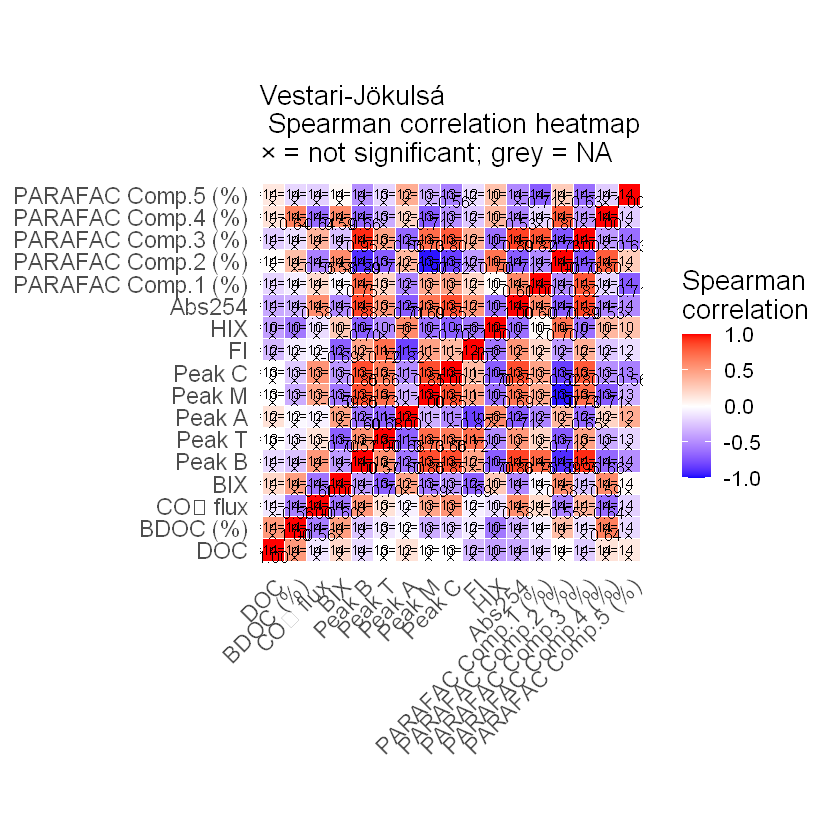

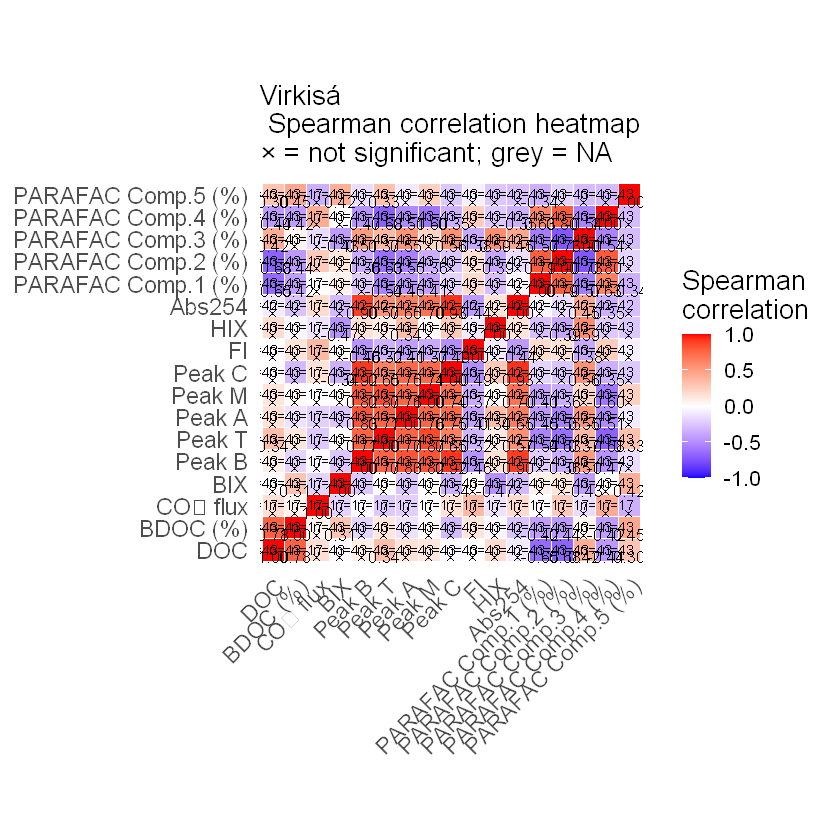

In [105]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type   <- "spearman"    # or "spearman"
group_filter <- "all"           # 1 = nur group_nr 1; "all" = alle Gruppen; z.B. 2 = nur group_nr 2

# Carbon (fix)
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Fluorescence (dein Set)
fluo_vars <- c(
  "bix", "b", "t", "a", "m", "c", "fi", "hix", "a254",
  "pctComp.1", "pctComp.2", "pctComp.3", "pctComp.4", "pctComp.5"
)

# Achsen: erst Carbon, dann Fluorescence
vars_keep <- c(carbon_vars, fluo_vars)

# Labels
rename_map <- c(
  average_DOC_sample = "DOC",
  BDOC_pct           = "BDOC (%)",
  CO2_Flux           = "CO₂ flux",
  bix                = "BIX",
  b                  = "Peak B",
  t                  = "Peak T",
  a                  = "Peak A",
  m                  = "Peak M",
  c                  = "Peak C",
  fi                 = "FI",
  hix                = "HIX",
  a254               = "Abs254",
  pctComp.1          = "PARAFAC Comp.1 (%)",
  pctComp.2          = "PARAFAC Comp.2 (%)",
  pctComp.3          = "PARAFAC Comp.3 (%)",
  pctComp.4          = "PARAFAC Comp.4 (%)",
  pctComp.5          = "PARAFAC Comp.5 (%)"
)

col_low  <- "blue"; col_mid  <- "white"; col_high <- "red"
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 gewünschte Spalten numerisch parsen
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

make_plot_fluo <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  d0 <- df_river %>% select(any_of(vars_keep))
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)

  # >>> NEU: Diagonale klassisch auf 1 setzen <<<
  diag(co$r) <- 1

  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2"))
    # (Diagonale NICHT entfernen)

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_chr = as.character(Var1),
      Var2_chr = as.character(Var2),
      is_diag  = Var1_chr == Var2_chr,
      Var1_lab = dplyr::recode(Var1_chr, !!!label_map, .default = Var1_chr),
      Var2_lab = dplyr::recode(Var2_chr, !!!label_map, .default = Var2_chr),
      Significant = Pvalue < 0.05,
      # Diagonale zuerst behandeln (zeigt 1.00)
      Label = dplyr::case_when(
        is_diag               ~ sprintf("%.2f", 1),
        is.na(Correlation)    ~ "n<3",
        Significant           ~ sprintf("%.2f", Correlation),
        TRUE                  ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    ) %>%
    select(-Var1_chr, -Var2_chr, -is_diag)

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste("group_nr=", group_filter))
  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Label), size = 3.5, fontface = "plain", vjust = 1) +
    geom_text(aes(label = Nlab), size = 3,
          hjust = 1.1, vjust = 1.3, nudge_x = 0.38, nudge_y = 0.45) +
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(size = 14, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = 14),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = 16, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  outfile <- file.path(out_dir, paste0("Heatmap_", river_id, "_Fluo_", group_label, "_",
                                       toTitleCase(corr_type), "_NAaware_Signif_English.png"))
  # Leerzeichen und = im Dateinamen durch _ ersetzen
  outfile <- gsub("[ =]", "_", outfile)
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_fluo("Vestari_Joekulsa")
make_plot_fluo("Virkisa")


# scat


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.27, p = 0.139 (n=31)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.27, p = 0.139 (n=31)' in 'mbcsToSbcs': Punkt ersetzt <81>"


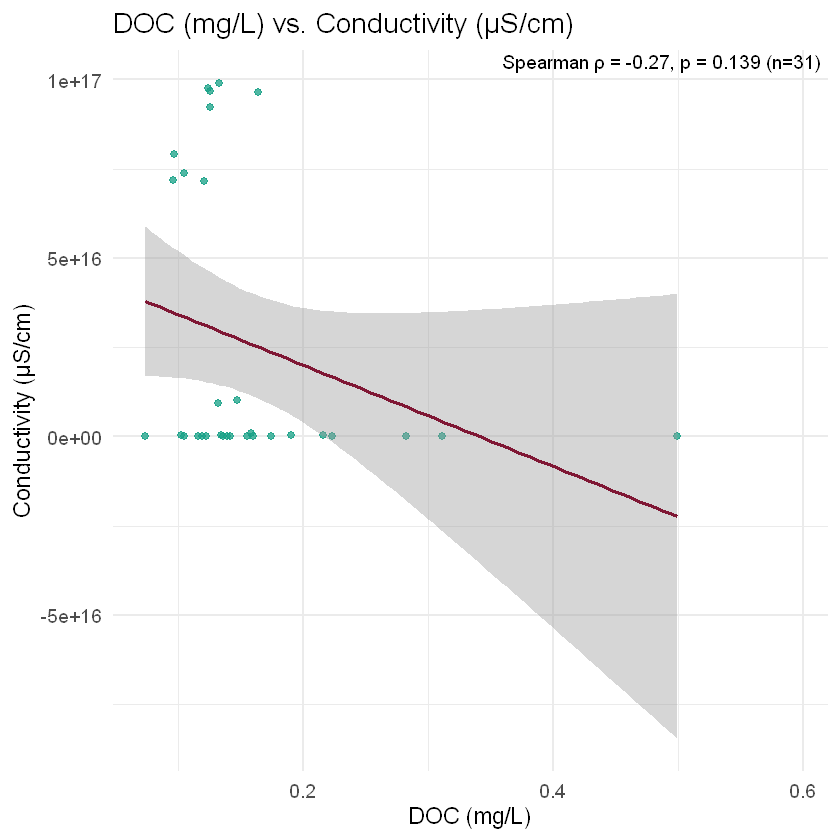

In [17]:
# 📦
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2)
})

# Daten
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# Helper: sicher zu numeric (Komma → Punkt, Tausenderpunkt weg)
as_numeric_safely <- function(x){
  if (is.numeric(x)) return(x)
  if (is.factor(x))  x <- as.character(x)
  if (is.character(x)) {
    x <- trimws(x)
    x[x %in% c("", "NA", "NaN")] <- NA
    x <- gsub("\\.", "", x)            # Tausenderpunkt entfernen
    x <- gsub(",", ".", x, fixed = TRUE)
  }
  suppressWarnings(as.numeric(x))
}

# Labels (Fallback auf Spaltenname)
label_map <- c(
  average_DOC_sample = "DOC (mg/L)",
  BDOC_pct           = "BDOC (%)",
  CO2_Flux           = "CO₂ flux",
  Cond_uSpercm_korr  = "Conductivity (µS/cm)",
  ODO_mgperL         = "Dissolved O₂ (mg/L)",
  a254               = "Abs254",
  hix                = "HIX"
)
lbl <- function(v) ifelse(!is.na(label_map[v]), label_map[v], v)

# Farben
col_pt <- "#16A085"  # türkis
col_ln <- "#7F1734"  # bordeaux

# Robuste Label-Berechnung (Spearman) + Fallbacks
spearman_label <- function(x, y){
  ok <- complete.cases(x, y)
  n  <- sum(ok)
  if (n < 3) return("n<3")
  if (sd(x[ok]) == 0 || sd(y[ok]) == 0) return("no variance")
  ct <- suppressWarnings(cor.test(x[ok], y[ok], method = "spearman", exact = FALSE))
  sprintf("Spearman \u03C1 = %.2f, p = %.3g (n=%d)", unname(ct$estimate), ct$p.value, n)
}

plot_scatter <- function(dat, xvar, yvar){
  # numerisch erzwingen
  x <- as_numeric_safely(dat[[xvar]])
  y <- as_numeric_safely(dat[[yvar]])
  ok <- complete.cases(x, y)
  df_xy <- data.frame(x=x, y=y)[ok, , drop=FALSE]

  # Label
  lab_txt <- spearman_label(x, y)

  p <- ggplot(data.frame(x=x, y=y), aes(x=x, y=y)) +
    geom_point(alpha = 0.75, size = 2, color = col_pt, na.rm = TRUE) +
    labs(x = lbl(xvar), y = lbl(yvar), title = paste(lbl(xvar), "vs.", lbl(yvar))) +
    theme_minimal(base_size = 14) +
    annotate("text", x = Inf, y = Inf, label = lab_txt, hjust = 1.02, vjust = 1.2, size = 4)

  # Regressionslinie nur, wenn genug Daten & Varianz
  if (nrow(df_xy) >= 3 && sd(df_xy$x) > 0 && sd(df_xy$y) > 0) {
    p <- p + geom_smooth(data = df_xy, aes(x=x, y=y),
                         method = "lm", se = TRUE, linewidth = 0.9,
                         color = col_ln, formula = y ~ x)
  }
  p
}

# Paare (nur echte Spaltennamen verwenden!)
pairs_to_plot <- list(
  c("average_DOC_sample", "Cond_uSpercm_korr"),  # DOC vs Conductivity
  c("CO2_Flux",           "ODO_mgperL"),         # CO2 flux vs DO
  c("BDOC_pct",           "a254"),               # BDOC vs Abs254
  c("average_DOC_sample", "hix")                 # DOC vs HIX
)

plots <- lapply(pairs_to_plot, \(v) plot_scatter(df, v[1], v[2]))
# anzeigen:
plots[[1]]
# library(patchwork); (plots[[1]] | plots[[2]]) / (plots[[3]] | plots[[4]])



--- Plot 1 ---


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.27, p = 0.139 (n=31)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.27, p = 0.139 (n=31)' in 'mbcsToSbcs': Punkt ersetzt <81>"



--- Plot 2 ---


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.88, p = 2.38e-09 (n=27)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.88, p = 2.38e-09 (n=27)' in 'mbcsToSbcs': Punkt ersetzt <81>"


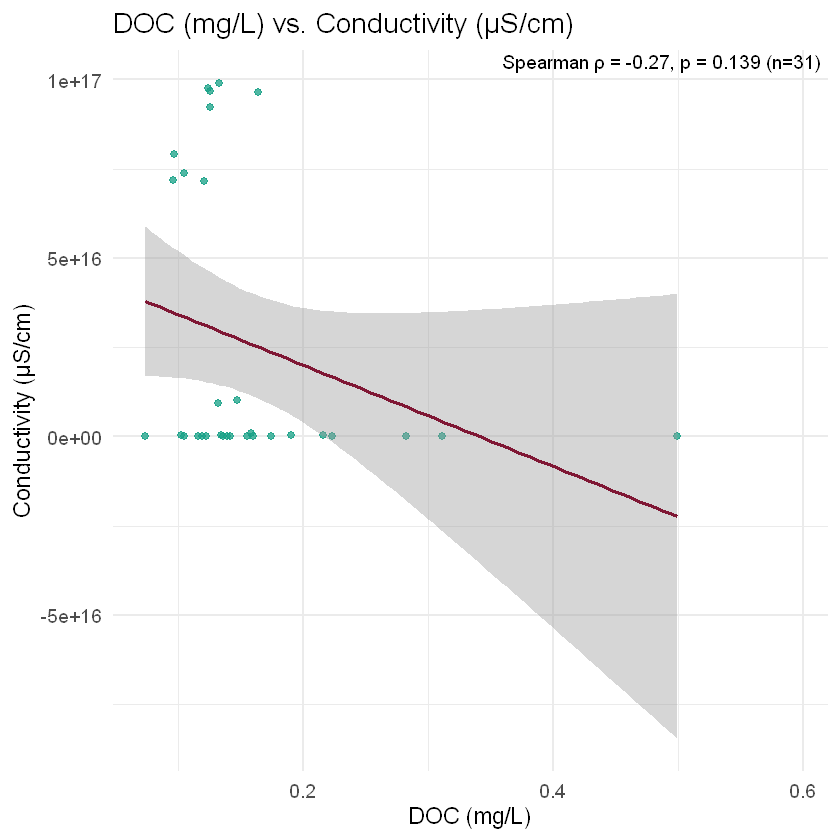


--- Plot 3 ---


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.25, p = 0.0684 (n=56)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.25, p = 0.0684 (n=56)' in 'mbcsToSbcs': Punkt ersetzt <81>"


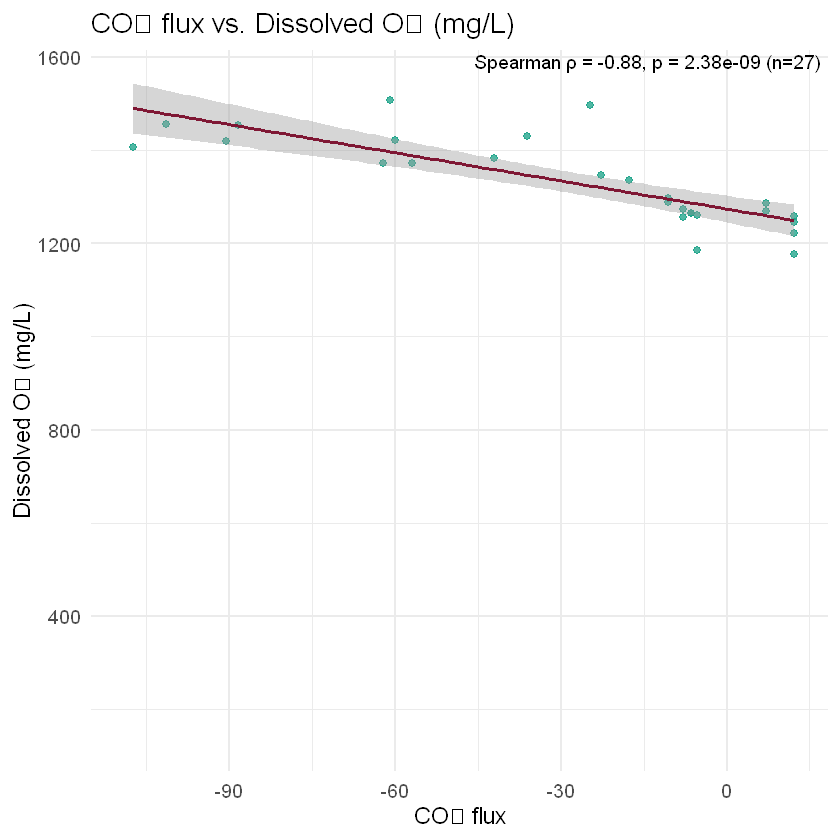


--- Plot 4 ---


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = 0.33, p = 0.0146 (n=53)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = 0.33, p = 0.0146 (n=53)' in 'mbcsToSbcs': Punkt ersetzt <81>"


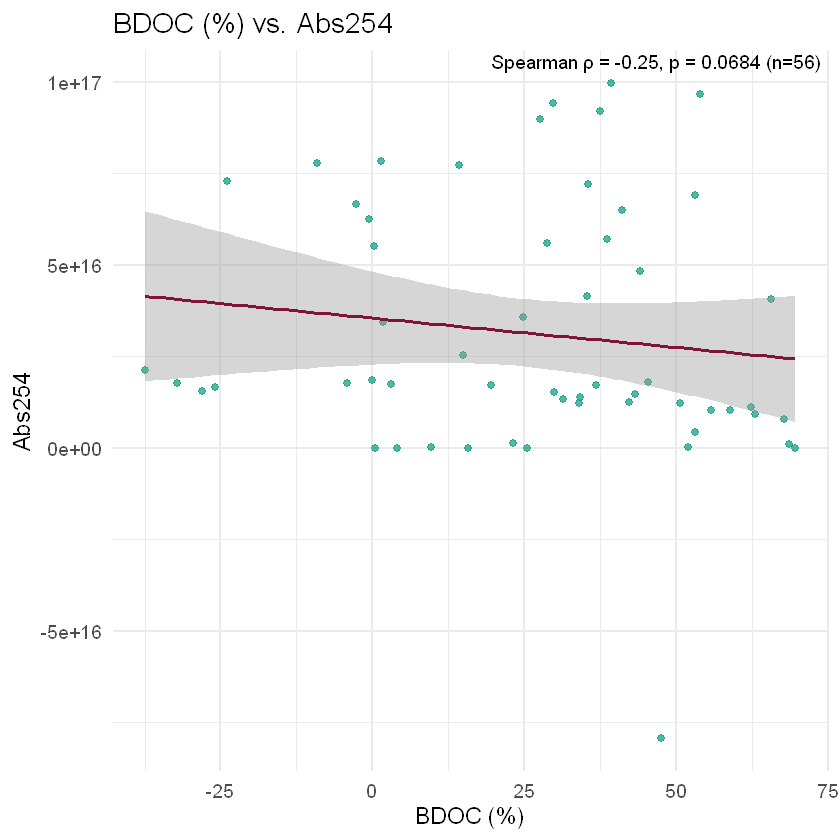

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.27, p = 0.139 (n=31)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.27, p = 0.139 (n=31)' in 'mbcsToSbcs': Punkt ersetzt <81>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.88, p = 2.38e-09 (n=27)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.88, p = 2.38e-09 (n=27)' in 'mbcsToSbcs': Punkt ersetzt <81>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.25, p = 0.0684 (n=56)' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsA

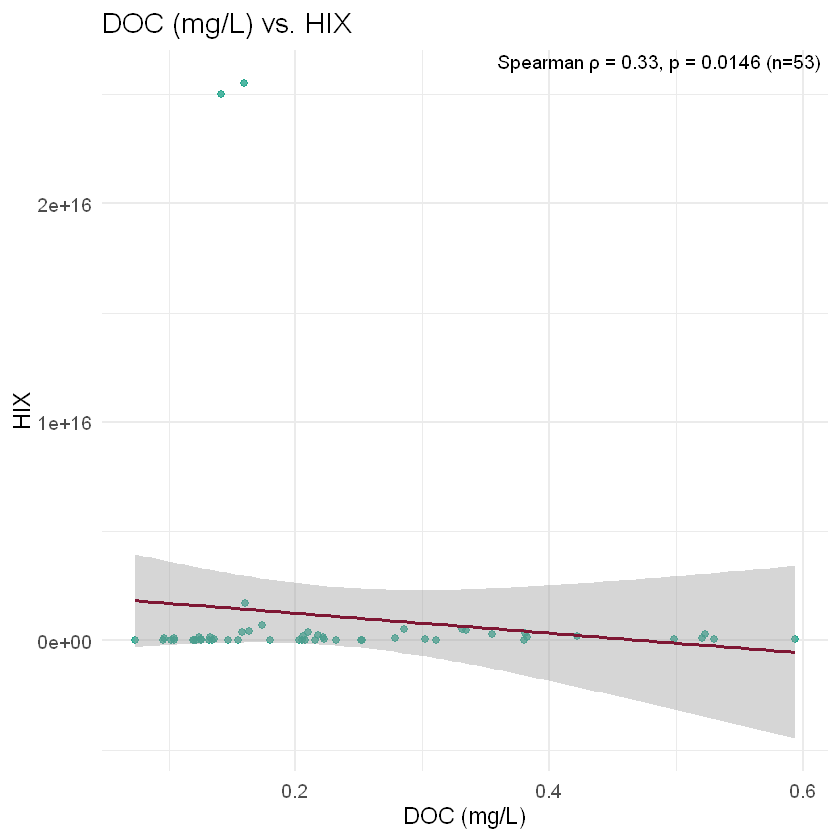

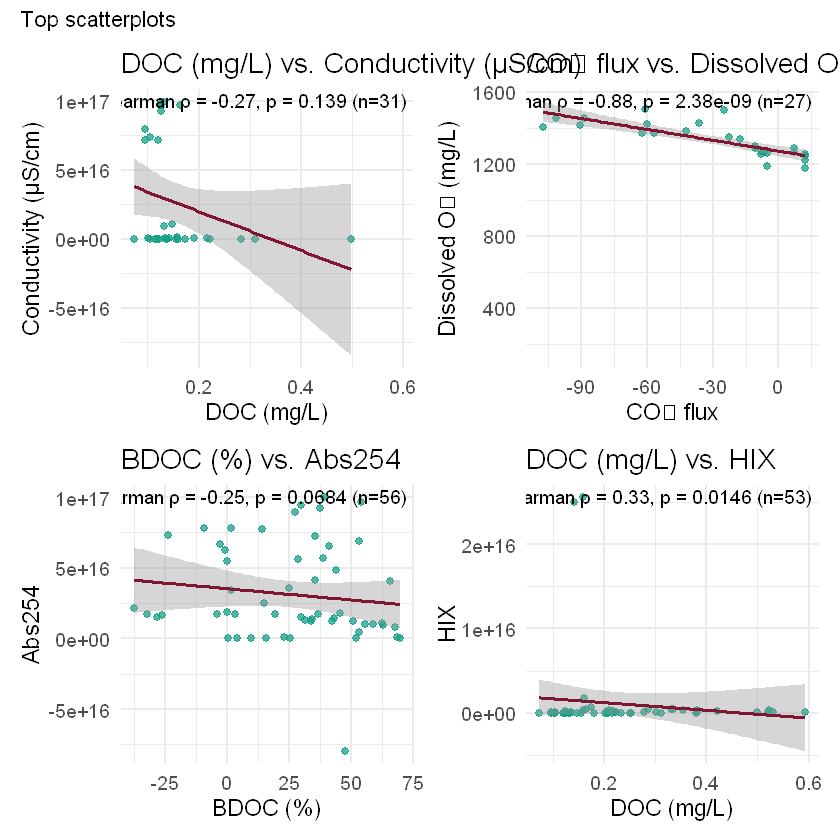

In [18]:
# 📦 falls noch nicht geladen
suppressPackageStartupMessages({ library(patchwork); library(ggplot2) })

# 🔹 1) Alle Plots nacheinander anzeigen
for (i in seq_along(plots)) {
  cat("\n--- Plot", i, "---\n")
  print(plots[[i]])
}

# 🔹 2) In einem Raster anzeigen
combined <- wrap_plots(plots, ncol = 2) + plot_annotation(title = "Top scatterplots")
combined  # anzeigen

# 🔹 3) Alle einzeln + kombiniert speichern
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Scatterplots"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

# Dateinamen aus den Variablenpaaren bauen
plot_names <- vapply(pairs_to_plot, function(v) paste0(v[1], "_vs_", v[2]), character(1))

# einzeln
for (i in seq_along(plots)) {
  fn <- file.path(out_dir, paste0("scatter_", plot_names[i], ".png"))
  ggsave(fn, plot = plots[[i]], width = 18, height = 14, units = "cm", dpi = 300)
}

# kombiniert
ggsave(file.path(out_dir, "scatter_combined.png"),
       plot = combined, width = 24, height = 18, units = "cm", dpi = 300)


# Scaterplots 

## DOC and air temp

`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.53' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.53' in 'mbcsToSbcs': Punkt ersetzt <81>"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


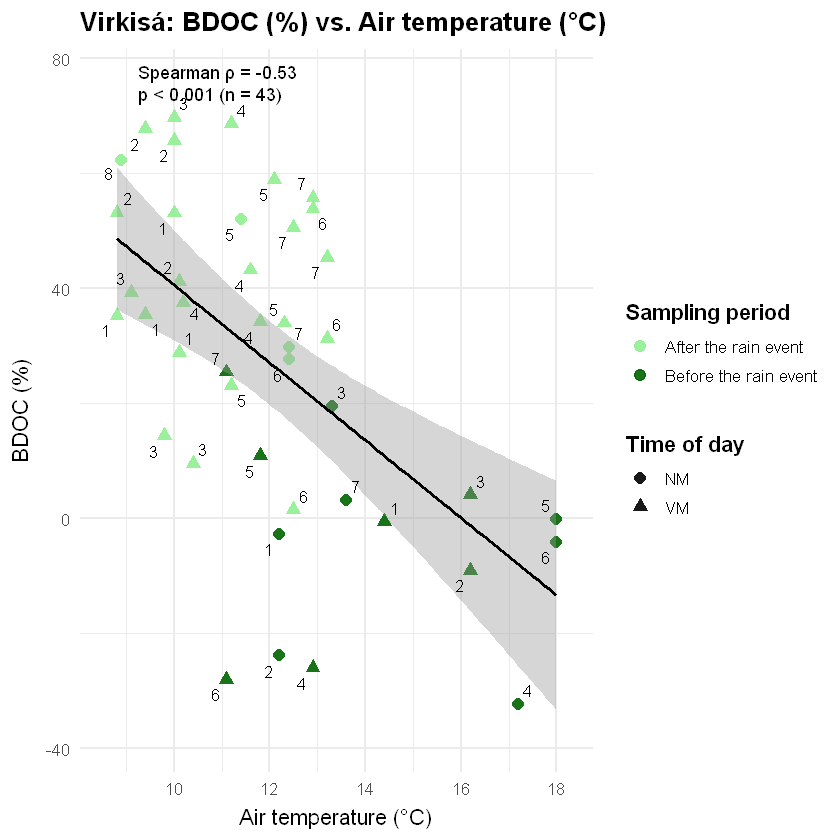

In [7]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ========== Pfad ==========
win_path  <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"

# ========== Daten laden & filtern ==========
dat <- readxl::read_excel(data_path) %>%
  select(river_name, BDOC_pct, Air_temp, day_time, site_nr, group_nr) %>%
  mutate(
    river_name = ifelse(grepl("Virkis", river_name, ignore.case = TRUE), "Virkisá", river_name),
    BDOC_pct   = suppressWarnings(as.numeric(BDOC_pct)),
    Air_temp   = suppressWarnings(as.numeric(Air_temp)),
    group_col  = ifelse(group_nr == 1, "Before the rain event", "After the rain event")
  ) %>%
  filter(river_name == "Virkisá", is.finite(BDOC_pct), is.finite(Air_temp))

stopifnot(nrow(dat) > 1)

# ========== Spearman ==========
rho <- suppressWarnings(cor(dat$BDOC_pct, dat$Air_temp, method = "spearman"))
p   <- suppressWarnings(cor.test(dat$BDOC_pct, dat$Air_temp, method = "spearman", exact = FALSE)$p.value)
p_lab <- if (is.na(p)) "p = NA" else if (p < 0.001) "p < 0.001" else if (p < 0.01) "p < 0.01" else if (p < 0.05) "p < 0.05" else paste0("p = ", signif(p, 2))
lab_txt <- paste0("Spearman \u03C1 = ", sprintf("%.2f", rho), "\n", p_lab, " (n = ", nrow(dat), ")")

# ========== Plot ==========
col_map   <- c("Before the rain event" = "#006400",   # dunkelgrün
               "After the rain event"  = "#90EE90")   # hellgrün
shape_map <- c("VM" = 17, "NM" = 16)                  # ▲ / ●

xr <- range(dat$Air_temp, na.rm = TRUE)
yr <- range(dat$BDOC_pct, na.rm = TRUE)

p <- ggplot(dat, aes(x = Air_temp, y = BDOC_pct)) +
  geom_point(aes(shape = day_time, color = group_col), size = 3, alpha = 0.9) +
  geom_smooth(method = "lm", se = TRUE, linewidth = 0.9, color = "black") +
  ggrepel::geom_text_repel(
    aes(label = site_nr),
    size = 3.4, max.overlaps = 80,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6
  ) +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  scale_color_manual(values = col_map, name = "Sampling period") +  # neue Legende
  labs(
    title = "Virkisá: BDOC (%) vs. Air temperature (°C)",
    x = "Air temperature (°C)",
    y = "BDOC (%)"
  ) +
  coord_cartesian(
    xlim = c(xr[1] - 0.03*diff(xr), xr[2] + 0.03*diff(xr)),
    ylim = c(yr[1] - 0.06*diff(yr), yr[2] + 0.06*diff(yr))
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 8)),
    axis.title.x = element_text(margin = margin(t = 6)),
    axis.title.y = element_text(margin = margin(r = 6)),
    legend.position = "right",
    legend.title = element_text(face = "bold")
  ) +
  annotate(
    "text",
    x = xr[1] + 0.05 * diff(xr),
    y = yr[2] + 0.03 * diff(yr),
    hjust = 0, vjust = 0,
    lineheight = 1.0, size = 3.8,
    label = lab_txt, color = "black"
  )

print(p)

# ========== Speichern ==========
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

ggsave(file.path(out_dir, "Scatter_Virkisa_BDOC_vs_AirTemp_A4_landscape.png"),
       plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)

ggsave(file.path(out_dir, "Scatter_Virkisa_BDOC_vs_AirTemp_A4_portrait.png"),
       plot = p, width = 21.0, height = 29.7, units = "cm", dpi = 300)


## DOC vs fDOM 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'ρ = 0.79, p < 0.001' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'ρ = 0.79, p < 0.001' in 'mbcsToSbcs': Punkt ersetzt <81>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'ρ = 0.57, p < 0.01' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'ρ = 0.57, p < 0.01' in 'mbcsToSbcs': Punkt ersetzt <81>"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using fo

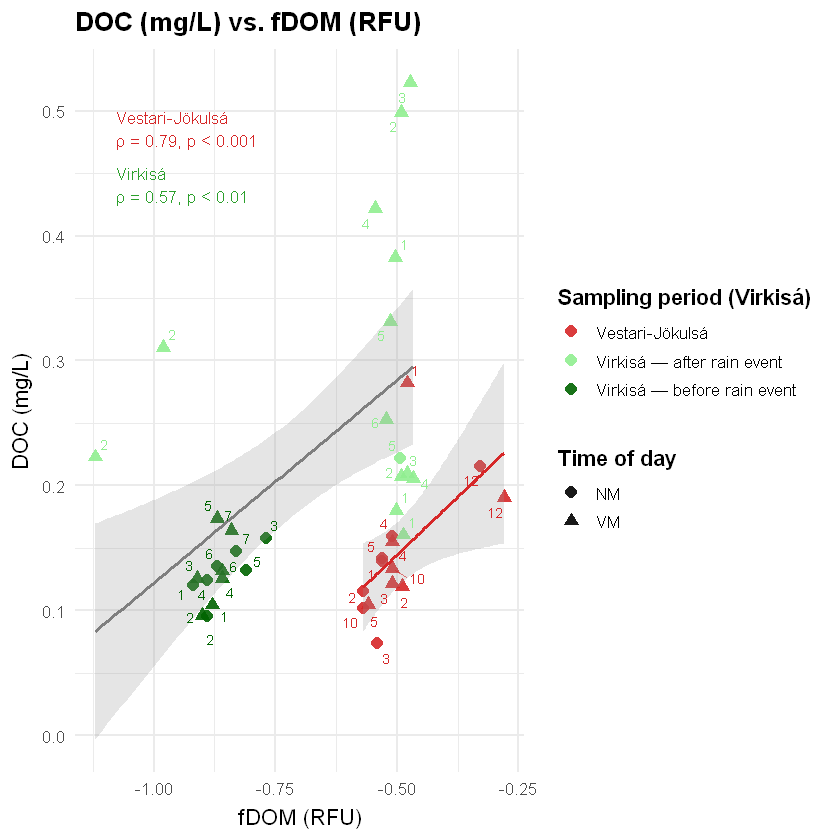

In [8]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ==== Path ====
win_path  <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Load ====
dat <- readxl::read_excel(data_path) %>%
  select(river_name, average_DOC_sample, fDOM_RFU, day_time, site_nr, group_nr) %>%  # group_nr dabei
  mutate(
    DOC  = suppressWarnings(as.numeric(average_DOC_sample)),
    fDOM = suppressWarnings(as.numeric(fDOM_RFU)),
    river_name = case_when(
      grepl("Vestari", river_name, ignore.case = TRUE) ~ "Vestari-Jökulsá",
      grepl("Virkis",  river_name, ignore.case = TRUE) ~ "Virkisá",
      TRUE ~ as.character(river_name)
    ),
    # Farb-Kategorie: Vestari rot; Virkisá je nach Periodenlabel
    col_cat = case_when(
      river_name == "Virkisá" & group_nr == 1 ~ "Virkisá — before rain event",
      river_name == "Virkisá" & group_nr != 1 ~ "Virkisá — after rain event",
      TRUE ~ "Vestari-Jökulsá"
    )
  ) %>%
  filter(river_name %in% c("Vestari-Jökulsá", "Virkisá"),
         is.finite(DOC), is.finite(fDOM))

stopifnot(nrow(dat) > 1)

# ==== Spearman per river (für Labels) ====
stats <- dat %>%
  group_by(river_name) %>%
  summarise(
    rho = suppressWarnings(cor(DOC, fDOM, method = "spearman")),
    p   = suppressWarnings(cor.test(DOC, fDOM, method = "spearman", exact = FALSE)$p.value),
    .groups = "drop"
  ) %>%
  mutate(
    p_lab = case_when(
      is.na(p) ~ "p = NA",
      p < 0.001 ~ "p < 0.001",
      p < 0.01  ~ "p < 0.01",
      p < 0.05  ~ "p < 0.05",
      TRUE ~ paste0("p = ", signif(p, 2))
    ),
    lab = paste0(river_name, "\n\u03C1 = ", sprintf("%.2f", rho), ", ", p_lab)
  )

# ==== Farben & Shapes ====
# Punkte: Vestari rot; Virkisá before/after grün/dunkelgrün
col_map_pts <- c(
  "Vestari-Jökulsá"              = "#D62728",
  "Virkisá — before rain event"  = "#006400",
  "Virkisá — after rain event"   = "#90EE90"
)
shape_map <- c("VM" = 17, "NM" = 16)  # ▲ vs ●

# Trendlinien-Farben (pro River, eine Linie je River)
col_map_lines <- c("Vestari-Jökulsá" = "#D62728",
                   "Virkisá"         = "#2CA02C")  # mittleres Grün

# ==== Plot ====
xr <- range(dat$fDOM, na.rm = TRUE)
yr <- range(dat$DOC,  na.rm = TRUE)

p <- ggplot(dat, aes(x = fDOM, y = DOC)) +
  # Punkte farblich je Sampling-Periode (nur Virkisá gesplittet)
  geom_point(aes(colour = col_cat, shape = day_time), size = 3, alpha = 0.9) +
  # Eine Regressionslinie je River (Farben nach River, nicht nach Sampling-Periode)
  geom_smooth(
    aes(group = river_name, colour = river_name),
    method = "lm", se = TRUE, linewidth = 0.9, alpha = 0.25, show.legend = FALSE
  ) +
  # Labels der Messstellen (Farbe wie Punkte)
  ggrepel::geom_text_repel(
    aes(label = site_nr, colour = col_cat),
    size = 3.0, max.overlaps = 80,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6, show.legend = FALSE
  ) +
  # Skalen
  scale_colour_manual(
    values = col_map_pts,
    name   = "Sampling period (Virkisá)"  # Legendentitel für Punkte
  ) +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  # Linienfarben separat setzen (keine Legende angezeigt)
  scale_fill_manual(values = c("Vestari-Jökulsá" = "grey70", "Virkisá" = "grey70"), guide = "none") +
  scale_colour_discrete(guide = "none") +
  labs(
    title = "DOC (mg/L) vs. fDOM (RFU)",
    x = "fDOM (RFU)",
    y = "DOC (mg/L)"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 8)),
    axis.title.x = element_text(margin = margin(t = 6)),
    axis.title.y = element_text(margin = margin(r = 6)),
    legend.position = "right",
    legend.title = element_text(face = "bold")
  ) +
  # Spearman-Labels pro River (Farblich zu den Linien)
  annotate("text",
           x = xr[1] + 0.05 * diff(xr),
           y = yr[2] - 0.05 * diff(yr),
           hjust = 0, vjust = 1,
           label = stats$lab[stats$river_name == "Vestari-Jökulsá"],
           colour = col_map_lines["Vestari-Jökulsá"], size = 3.6, lineheight = 1.1) +
  annotate("text",
           x = xr[1] + 0.05 * diff(xr),
           y = yr[2] - 0.15 * diff(yr),
           hjust = 0, vjust = 1,
           label = stats$lab[stats$river_name == "Virkisá"],
           colour = col_map_lines["Virkisá"], size = 3.6, lineheight = 1.1)

# WICHTIG: Linienfarben manuell, damit die zwei Linien farblich passen
p <- p + scale_colour_manual(values = col_map_pts, name = "Sampling period (Virkisá)") +
         guides(colour = guide_legend(override.aes = list(shape = 16)))

print(p)

# ==== Save (A4, cm) ====
ggsave(file.path(out_dir, "Scatter_DOC_vs_fDOM_VirkisaPeriods_ONEline_per_river_A4_landscape.png"),
       plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)
ggsave(file.path(out_dir, "Scatter_DOC_vs_fDOM_VirkisaPeriods_ONEline_per_river_A4_portrait.png"),
       plot = p, width = 21.0, height = 29.7, units = "cm", dpi = 300)


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


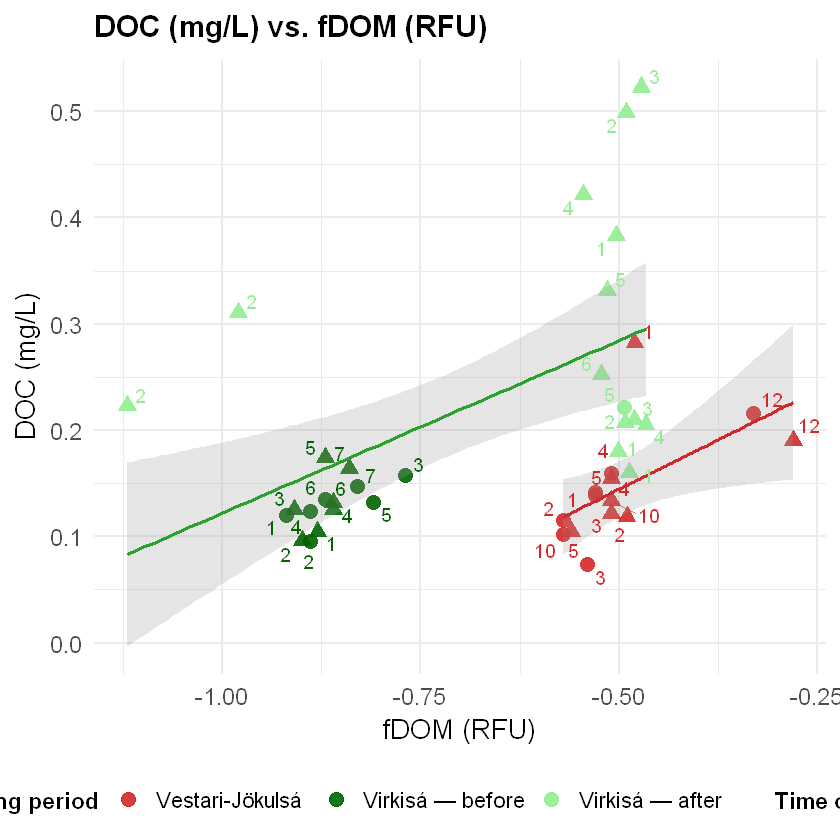

In [23]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden ====
raw <- readxl::read_excel(data_path)

dat <- raw %>%
  select(river_name, group_nr, day_time, site_nr,
         average_DOC_sample, fDOM_RFU) %>%
  mutate(
    river_name = case_when(
      grepl("Vestari", river_name, ignore.case = TRUE) ~ "Vestari-Jökulsá",
      grepl("Virkis",  river_name, ignore.case = TRUE) ~ "Virkisá",
      TRUE ~ as.character(river_name)
    ),
    DOC   = suppressWarnings(as.numeric(average_DOC_sample)),
    fDOM  = suppressWarnings(as.numeric(fDOM_RFU)),
    period_cat = case_when(
      river_name == "Virkisá" & group_nr == 1 ~ "Virkisá — before",
      river_name == "Virkisá" & group_nr != 1 ~ "Virkisá — after",
      river_name == "Vestari-Jökulsá"        ~ "Vestari-Jökulsá",
      TRUE ~ "other"
    )
  ) %>%
  filter(river_name %in% c("Vestari-Jökulsá","Virkisá"),
         is.finite(DOC), is.finite(fDOM))

stopifnot(nrow(dat) > 1)

# ==== Farben & Shapes ====
col_points <- c(
  "Vestari-Jökulsá"  = "#D62728",  # rot
  "Virkisá — before" = "#006400",  # dunkelgrün
  "Virkisá — after"  = "#90EE90"   # hellgrün
)
shape_map <- c("VM" = 17, "NM" = 16)     # ▲ / ●
col_lines <- c("Vestari-Jökulsá" = "#D62728", "Virkisá" = "#2CA02C")  # Linien pro River

# ==== Plot ====
p <- ggplot(dat, aes(x = fDOM, y = DOC)) +
  geom_point(aes(colour = period_cat, shape = day_time), size = 3.8, alpha = 0.9) +
  geom_smooth(
    aes(group = river_name, colour = river_name),
    method = "lm", se = TRUE, linewidth = 1.0, alpha = 0.25, show.legend = FALSE
  ) +
  ggrepel::geom_text_repel(
    aes(label = site_nr, colour = period_cat),
    size = 4.0, max.overlaps = 100,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6,
    show.legend = FALSE
  ) +
  scale_colour_manual(
    values = c(col_points, col_lines),
    breaks = names(col_points),
    name   = "River / Sampling period"
  ) +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  labs(
    title = "DOC (mg/L) vs. fDOM (RFU)",
    x = "fDOM (RFU)",
    y = "DOC (mg/L)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 10), size = 18),
    axis.title.x = element_text(size = 16, margin = margin(t = 6)),
    axis.title.y = element_text(size = 16, margin = margin(r = 6)),
    axis.text    = element_text(size = 14),
    legend.position = "bottom",
    legend.box = "horizontal",
    legend.title = element_text(face = "bold", size = 14),
    legend.text  = element_text(size = 13)
  )

print(p)

# ==== Speichern (A4 quer, cm) ====
ggsave(file.path(out_dir, "Scatter_DOC_vs_fDOM_Vestari_Virkisa_labels_A4_landscape.png"),
       plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)


## SpCond_uSpercm_korr

`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.78' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.78' in 'mbcsToSbcs': Punkt ersetzt <81>"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.74' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.74' in 'mbcsToSbcs': Punkt ersetzt <81>"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


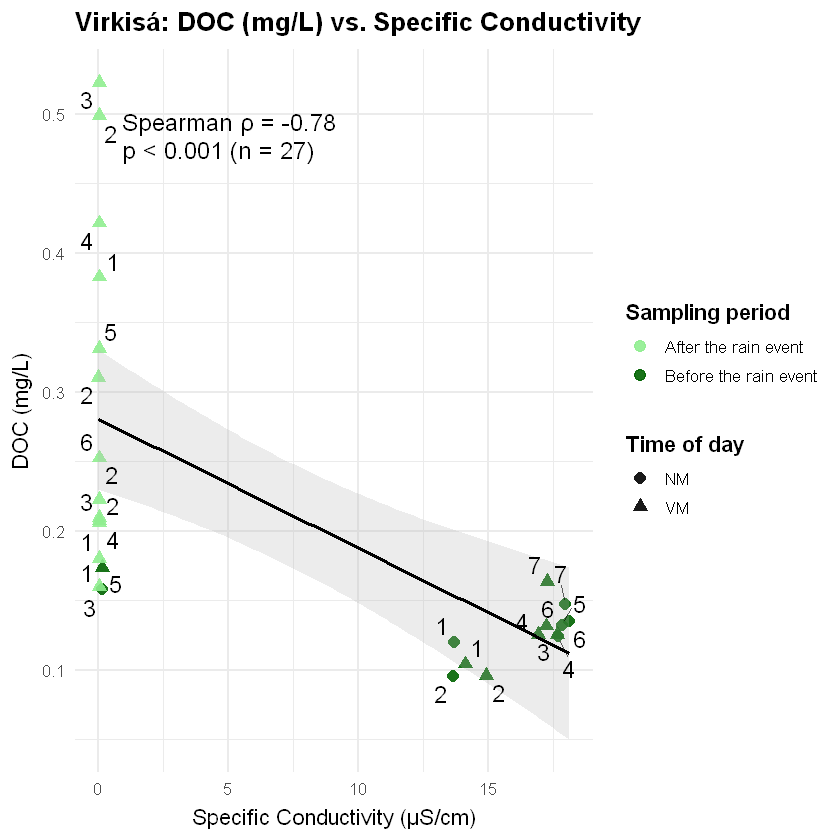

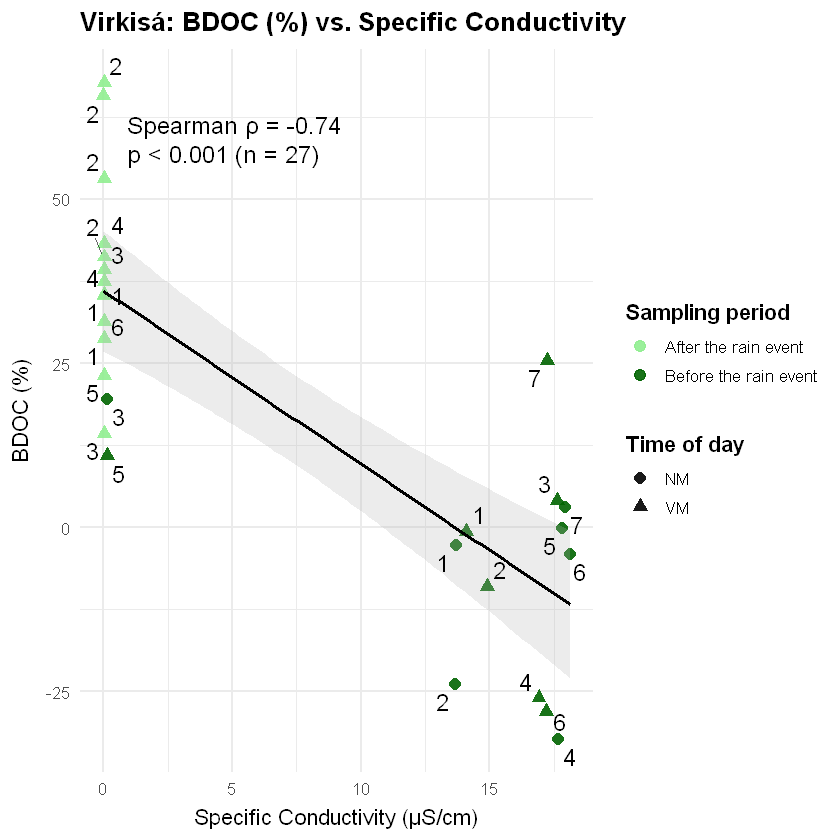

In [11]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden & filtern (nur Virkisá) ====
dat <- readxl::read_excel(data_path) %>%
  select(river_name, average_DOC_sample, BDOC_pct, SpCond_uSpercm_korr,
         day_time, site_nr, group_nr) %>%                           # group_nr dazu
  mutate(
    river_name = ifelse(grepl("Virkis", river_name, ignore.case = TRUE), "Virkisá", river_name),
    DOC    = suppressWarnings(as.numeric(average_DOC_sample)),
    BDOC   = suppressWarnings(as.numeric(BDOC_pct)),
    SpCond = suppressWarnings(as.numeric(SpCond_uSpercm_korr)),
    period = ifelse(group_nr == 1, "Before the rain event", "After the rain event")
  ) %>%
  filter(river_name == "Virkisá",
         is.finite(DOC), is.finite(BDOC), is.finite(SpCond))

stopifnot(nrow(dat) > 1)

# ==== Styling ====
shape_map <- c("VM" = 17, "NM" = 16)  # ▲ vs ●
col_map   <- c("Before the rain event" = "#006400",
               "After the rain event"  = "#90EE90")

plot_one <- function(df, yvar, ylab, file_stub){

  # Spearman (gesamt)
  y   <- df[[yvar]]
  rho <- suppressWarnings(cor(y, df$SpCond, method = "spearman", use = "complete.obs"))
  p   <- suppressWarnings(cor.test(y, df$SpCond, method = "spearman", exact = FALSE)$p.value)
  p_lab <- if (is.na(p)) "p = NA" else if (p < 0.001) "p < 0.001" else if (p < 0.01) "p < 0.01" else if (p < 0.05) "p < 0.05" else paste0("p = ", signif(p, 2))
  lab_txt <- paste0("Spearman \u03C1 = ", sprintf("%.2f", rho), "\n", p_lab,
                    " (n = ", sum(complete.cases(y, df$SpCond)), ")")

  xr <- range(df$SpCond, na.rm = TRUE); yr <- range(y, na.rm = TRUE)

  p <- ggplot(df, aes(x = SpCond, y = .data[[yvar]])) +
    geom_point(aes(shape = day_time, colour = period), size = 3, alpha = 0.9) +
    geom_smooth(aes(group = 1), method = "lm", se = TRUE, linewidth = 0.9,
                color = "black", fill = "grey70", alpha = 0.25) +
    ggrepel::geom_text_repel(aes(label = site_nr),
                             size = 5.0, max.overlaps = 80,
                             box.padding = 0.25, point.padding = 0.2,
                             segment.size = 0.2, segment.alpha = 0.6, color = "black") +
    scale_shape_manual(values = shape_map, name = "Time of day") +
    scale_colour_manual(values = col_map, name = "Sampling period") +
    labs(
      title = paste0("Virkisá: ", ylab, " vs. Specific Conductivity"),
      x = "Specific Conductivity (µS/cm)",
      y = ylab
    ) +
    theme_minimal(base_size = 13) +
    theme(
      plot.title   = element_text(face = "bold", margin = margin(b = 8)),
      axis.title.x = element_text(margin = margin(t = 6)),
      axis.title.y = element_text(margin = margin(r = 6)),
      legend.position = "right",
      legend.title = element_text(face = "bold")
    ) +
    annotate("text",
             x = xr[1] + 0.05*diff(xr),
             y = yr[2] - 0.05*diff(yr),
             hjust = 0, vjust = 1, lineheight = 1.0, size = 5 , #3.6
             label = lab_txt, color = "black")

  print(p)

  # Speichern (A4)
  ggsave(file.path(out_dir, paste0(file_stub, "_A4_landscape.png")),
         plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)
  ggsave(file.path(out_dir, paste0(file_stub, "_A4_portrait.png")),
         plot = p, width = 21.0, height = 29.7, units = "cm", dpi = 300)
}

# ==== Plots erzeugen ====
plot_one(dat, "DOC",  "DOC (mg/L)",  "Scatter_Virkisa_DOC_vs_SpCond")
plot_one(dat, "BDOC", "BDOC (%)",    "Scatter_Virkisa_BDOC_vs_SpCond")


`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.78' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.78' in 'mbcsToSbcs': Punkt ersetzt <81>"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.74' in 'mbcsToSbcs': Punkt ersetzt <cf>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Spearman ρ = -0.74' in 'mbcsToSbcs': Punkt ersetzt <81>"
`geom_smooth()` using formula = 'y ~ x'


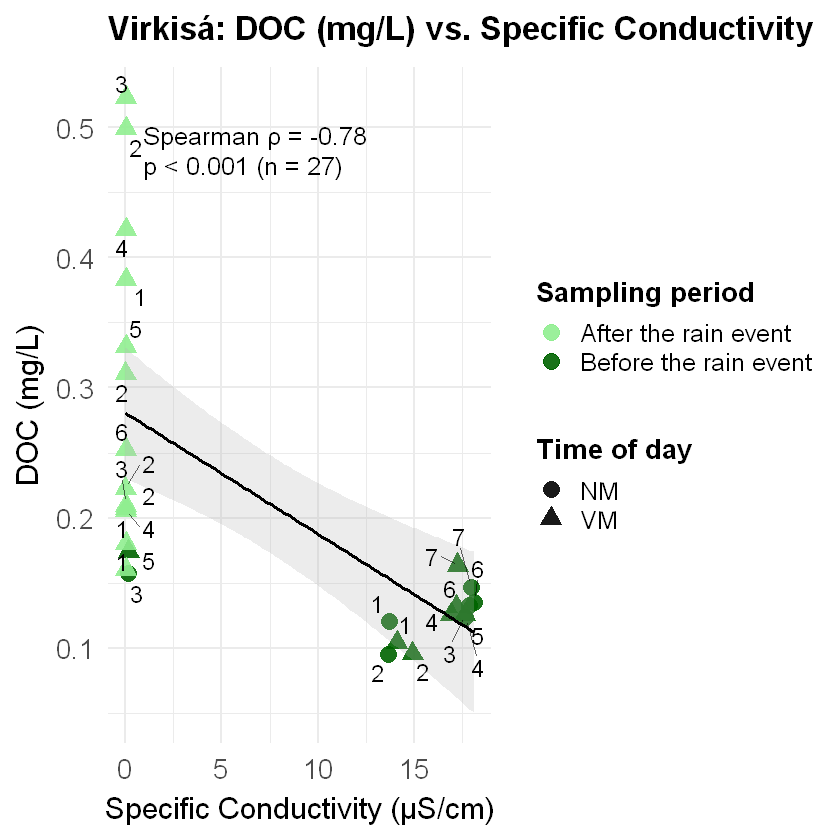

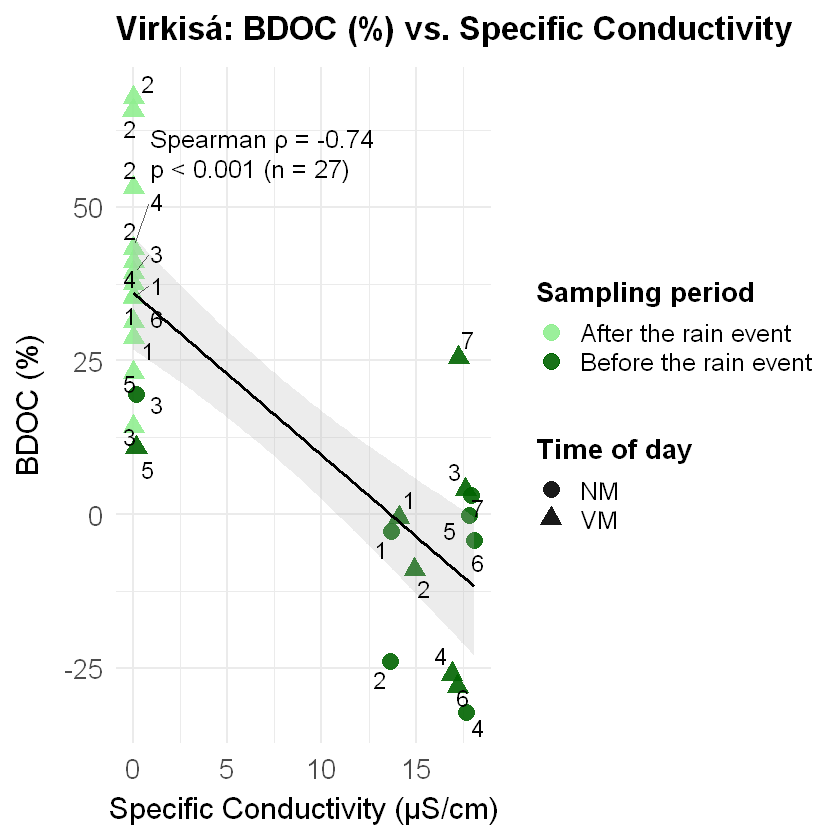

In [14]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden & filtern (nur Virkisá) ====
dat <- readxl::read_excel(data_path) %>%
  select(river_name, average_DOC_sample, BDOC_pct, SpCond_uSpercm_korr,
         day_time, site_nr, group_nr) %>%
  mutate(
    river_name = ifelse(grepl("Virkis", river_name, ignore.case = TRUE), "Virkisá", river_name),
    DOC    = suppressWarnings(as.numeric(average_DOC_sample)),
    BDOC   = suppressWarnings(as.numeric(BDOC_pct)),
    SpCond = suppressWarnings(as.numeric(SpCond_uSpercm_korr)),
    period = ifelse(group_nr == 1, "Before the rain event", "After the rain event")
  ) %>%
  filter(river_name == "Virkisá",
         is.finite(DOC), is.finite(BDOC), is.finite(SpCond))

stopifnot(nrow(dat) > 1)

# ==== Styling ====
shape_map <- c("VM" = 17, "NM" = 16)  # ▲ vs ●
col_map   <- c("Before the rain event" = "#006400",
               "After the rain event"  = "#90EE90")

plot_one <- function(df, yvar, ylab, file_stub){
  # Spearman (gesamt)
  y   <- df[[yvar]]
  rho <- suppressWarnings(cor(y, df$SpCond, method = "spearman", use = "complete.obs"))
  p   <- suppressWarnings(cor.test(y, df$SpCond, method = "spearman", exact = FALSE)$p.value)
  p_lab <- if (is.na(p)) "p = NA" else if (p < 0.001) "p < 0.001" else if (p < 0.01) "p < 0.01" else if (p < 0.05) "p < 0.05" else paste0("p = ", signif(p, 2))
  lab_txt <- paste0("Spearman \u03C1 = ", sprintf("%.2f", rho), "\n", p_lab,
                    " (n = ", sum(complete.cases(y, df$SpCond)), ")")

  xr <- range(df$SpCond, na.rm = TRUE); yr <- range(y, na.rm = TRUE)

  p <- ggplot(df, aes(x = SpCond, y = .data[[yvar]])) +
    geom_point(aes(shape = day_time, colour = period), size = 4.5, alpha = 0.9) +  # größere Punkte
    geom_smooth(aes(group = 1), method = "lm", se = TRUE, linewidth = 1.1,
                color = "black", fill = "grey70", alpha = 0.25) +
    ggrepel::geom_text_repel(aes(label = site_nr),
                             size = 5.0, max.overlaps = 100,  # größere Punktbeschriftung
                             box.padding = 0.3, point.padding = 0.25,
                             segment.size = 0.3, segment.alpha = 0.6, color = "black") +
    scale_shape_manual(values = shape_map, name = "Time of day") +
    scale_colour_manual(values = col_map, name = "Sampling period") +
    labs(
      title = paste0("Virkisá: ", ylab, " vs. Specific Conductivity"),
      x = "Specific Conductivity (µS/cm)",
      y = ylab
    ) +
    theme_minimal(base_size = 18) +
    theme(
      plot.title   = element_text(face = "bold", margin = margin(b = 12), size = 20),
      axis.title.x = element_text(size = 18, margin = margin(t = 8)),
      axis.title.y = element_text(size = 18, margin = margin(r = 8)),
      axis.text    = element_text(size = 16),  # größere Ticks
      legend.position = "right",
      legend.title = element_text(face = "bold", size = 16),
      legend.text  = element_text(size = 15)
    ) +
    annotate("text",
             x = xr[1] + 0.05*diff(xr),
             y = yr[2] - 0.05*diff(yr),
             hjust = 0, vjust = 1, lineheight = 1.0, size = 5.2,
             label = lab_txt, color = "black")

  print(p)

  # Speichern: ganze A4 quer (Landscape)
  ggsave(file.path(out_dir, paste0(file_stub, "_A4_landscape.png")),
         plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)
}

# ==== Plots getrennt erzeugen ====
plot_one(dat, "DOC",  "DOC (mg/L)",  "Scatter_Virkisa_DOC_vs_SpCond")
plot_one(dat, "BDOC", "BDOC (%)",    "Scatter_Virkisa_BDOC_vs_SpCond")


## comp

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


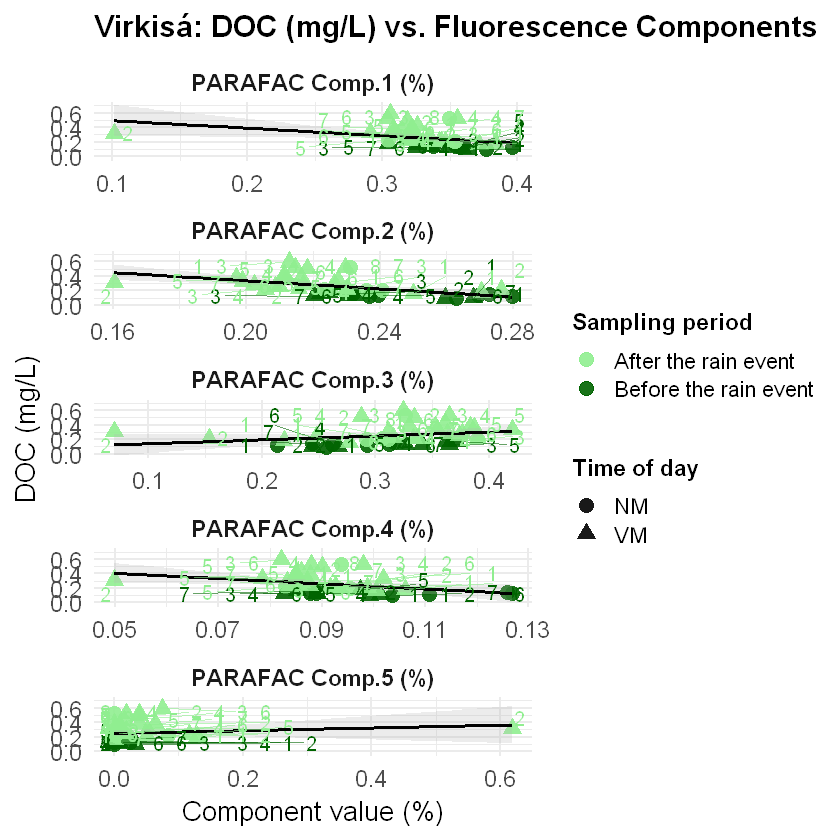

In [16]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden (nur Virkisá) ====
raw <- readxl::read_excel(data_path)

# Fluoreszenz-Komponenten
comp_cols_all <- c("pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5")
comp_cols <- intersect(comp_cols_all, names(raw))
stopifnot(length(comp_cols) > 0)

dat <- raw %>%
  select(river_name, group_nr, day_time, site_nr,
         average_DOC_sample, all_of(comp_cols)) %>%
  mutate(
    river_name = ifelse(grepl("Virkis", river_name, ignore.case = TRUE), "Virkisá", river_name),
    DOC = suppressWarnings(as.numeric(average_DOC_sample)),
    period = ifelse(group_nr == 1, "Before the rain event", "After the rain event")
  ) %>%
  filter(river_name == "Virkisá") %>%
  mutate(across(all_of(comp_cols), ~ suppressWarnings(as.numeric(.)))) %>%
  pivot_longer(all_of(comp_cols), names_to = "Component", values_to = "Comp_value") %>%
  filter(is.finite(DOC), is.finite(Comp_value))

stopifnot(nrow(dat) > 1)

# ==== Stil ====
col_map   <- c("Before the rain event" = "#006400", "After the rain event" = "#90EE90")
shape_map <- c("VM" = 17, "NM" = 16)
nice_lab  <- c(
  "pctComp.1"="PARAFAC Comp.1 (%)","pctComp.2"="PARAFAC Comp.2 (%)",
  "pctComp.3"="PARAFAC Comp.3 (%)","pctComp.4"="PARAFAC Comp.4 (%)",
  "pctComp.5"="PARAFAC Comp.5 (%)"
)

# ==== Plot ====
p <- ggplot(dat, aes(x = Comp_value, y = DOC)) +
  geom_point(aes(color = period, shape = day_time), size = 3.8, alpha = 0.9) +
  geom_smooth(aes(group = 1), method = "lm", se = TRUE, linewidth = 0.9,
              color = "black", fill = "grey70", alpha = 0.25) +
  ggrepel::geom_text_repel(
    aes(label = site_nr, color = period),
    size = 4.2, max.overlaps = 80,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6,
    show.legend = FALSE
  ) +
  scale_color_manual(values = col_map, name = "Sampling period") +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  facet_wrap(~ Component, ncol = 1, labeller = as_labeller(nice_lab), scales = "free_x") +
  labs(
    title = "Virkisá: DOC (mg/L) vs. Fluorescence Components",
    x = "Component value (%)",
    y = "DOC (mg/L)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 10), size = 18),
    axis.title.x = element_text(size = 16, margin = margin(t = 6)),
    axis.title.y = element_text(size = 16, margin = margin(r = 6)),
    axis.text    = element_text(size = 14),
    strip.text   = element_text(size = 14, face = "bold"),
    legend.position = "right",
    legend.title = element_text(face = "bold", size = 14),
    legend.text  = element_text(size = 13)
  )

print(p)

# ==== Speichern ====
ggsave(file.path(out_dir, "Scatter_Virkisa_DOC_vs_ParafacComponents_facets_vertical_labels_A4_portrait.png"),
       plot = p, width = 21.0, height = 29.7, units = "cm", dpi = 300)


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


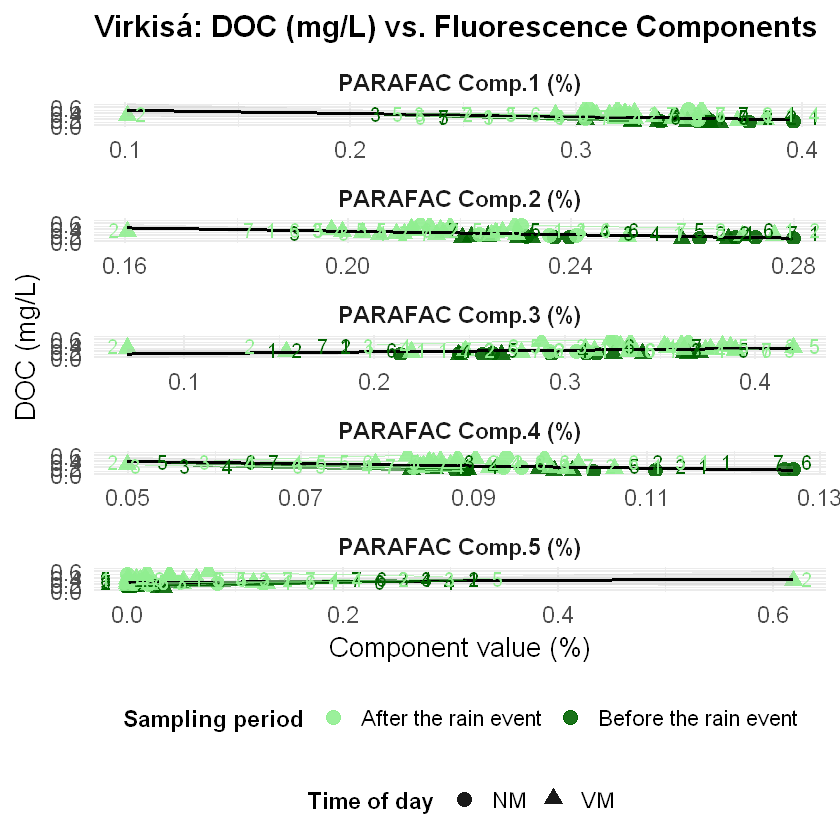

In [18]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden (nur Virkisá) ====
raw <- readxl::read_excel(data_path)

comp_cols_all <- c("pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5")
comp_cols <- intersect(comp_cols_all, names(raw))
stopifnot(length(comp_cols) > 0)

dat <- raw %>%
  select(river_name, group_nr, day_time, site_nr,
         average_DOC_sample, all_of(comp_cols)) %>%
  mutate(
    river_name = ifelse(grepl("Virkis", river_name, ignore.case = TRUE), "Virkisá", river_name),
    DOC = suppressWarnings(as.numeric(average_DOC_sample)),
    period = ifelse(group_nr == 1, "Before the rain event", "After the rain event")
  ) %>%
  filter(river_name == "Virkisá") %>%
  mutate(across(all_of(comp_cols), ~ suppressWarnings(as.numeric(.)))) %>%
  pivot_longer(all_of(comp_cols), names_to = "Component", values_to = "Comp_value") %>%
  filter(is.finite(DOC), is.finite(Comp_value))

# ==== Stil ====
col_map   <- c("Before the rain event" = "#006400", "After the rain event" = "#90EE90")
shape_map <- c("VM" = 17, "NM" = 16)
nice_lab  <- c(
  "pctComp.1"="PARAFAC Comp.1 (%)","pctComp.2"="PARAFAC Comp.2 (%)",
  "pctComp.3"="PARAFAC Comp.3 (%)","pctComp.4"="PARAFAC Comp.4 (%)",
  "pctComp.5"="PARAFAC Comp.5 (%)"
)

# ==== Plot ====
p <- ggplot(dat, aes(x = Comp_value, y = DOC)) +
  geom_point(aes(color = period, shape = day_time), size = 3.8, alpha = 0.9) +
  geom_smooth(aes(group = 1), method = "lm", se = TRUE, linewidth = 0.9,
              color = "black", fill = "grey70", alpha = 0.25) +
  ggrepel::geom_text_repel(
    aes(label = site_nr, color = period),
    size = 4.2, max.overlaps = 80,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6,
    show.legend = FALSE
  ) +
  scale_color_manual(values = col_map, name = "Sampling period") +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  facet_wrap(~ Component, ncol = 1, labeller = as_labeller(nice_lab), scales = "free_x") +
  labs(
    title = "Virkisá: DOC (mg/L) vs. Fluorescence Components",
    x = "Component value (%)",
    y = "DOC (mg/L)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 10), size = 18),
    axis.title.x = element_text(size = 16, margin = margin(t = 6)),
    axis.title.y = element_text(size = 16, margin = margin(r = 6)),
    axis.text    = element_text(size = 14),
    strip.text   = element_text(size = 14, face = "bold"),
    legend.position = "bottom",
    legend.box    = "vertical",
    legend.title  = element_text(face = "bold", size = 14),
    legend.text   = element_text(size = 13),
    panel.spacing = unit(0.6, "lines")   # enger: weniger Abstand zwischen Facets
  )

print(p)

# ==== Speichern (etwas höher als 21 cm) ====
ggsave(file.path(out_dir, "Scatter_Virkisa_DOC_vs_ParafacComponents_facets_vertical_labels_A4_landscape_taller.png"),
       plot = p, width = 29.7, height = 23.0, units = "cm", dpi = 300)


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


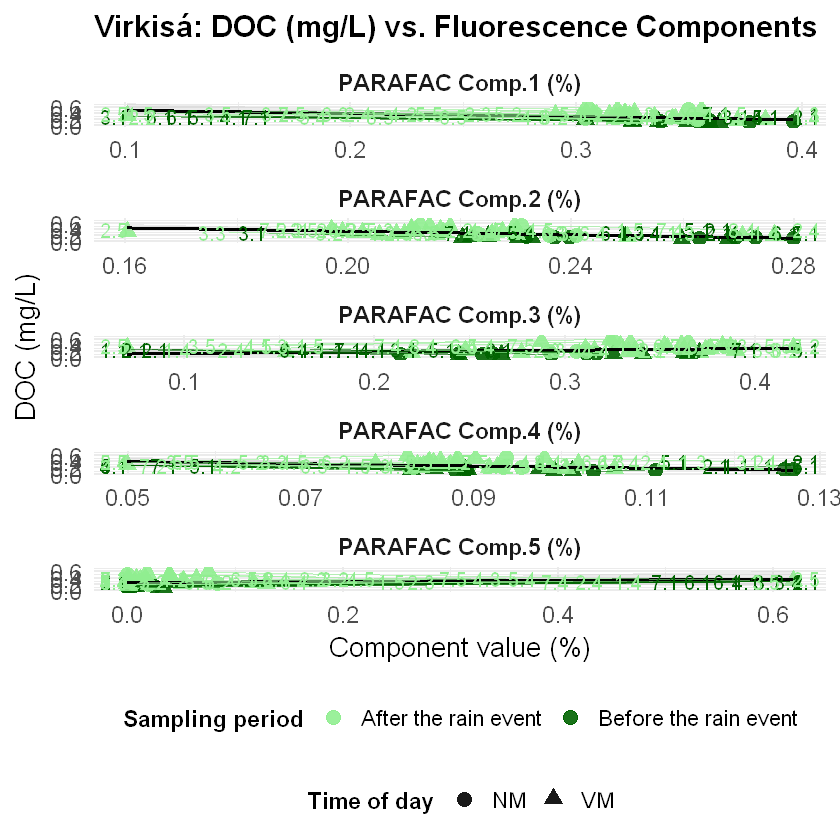

In [24]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden (nur Virkisá) ====
raw <- readxl::read_excel(data_path)

comp_cols_all <- c("pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5")
comp_cols <- intersect(comp_cols_all, names(raw))
stopifnot(length(comp_cols) > 0)

dat <- raw %>%
  select(river_name, group_nr, day_time, site_nr,
         average_DOC_sample, all_of(comp_cols)) %>%
  mutate(
    river_name = ifelse(grepl("Virkis", river_name, ignore.case = TRUE), "Virkisá", river_name),
    DOC = suppressWarnings(as.numeric(average_DOC_sample)),
    period = ifelse(group_nr == 1, "Before the rain event", "After the rain event"),
    label_txt = paste0(site_nr, ".", group_nr)   # neue Labels
  ) %>%
  filter(river_name == "Virkisá") %>%
  mutate(across(all_of(comp_cols), ~ suppressWarnings(as.numeric(.)))) %>%
  pivot_longer(all_of(comp_cols), names_to = "Component", values_to = "Comp_value") %>%
  filter(is.finite(DOC), is.finite(Comp_value))

# ==== Stil ====
col_map   <- c("Before the rain event" = "#006400", "After the rain event" = "#90EE90")
shape_map <- c("VM" = 17, "NM" = 16)
nice_lab  <- c(
  "pctComp.1"="PARAFAC Comp.1 (%)","pctComp.2"="PARAFAC Comp.2 (%)",
  "pctComp.3"="PARAFAC Comp.3 (%)","pctComp.4"="PARAFAC Comp.4 (%)",
  "pctComp.5"="PARAFAC Comp.5 (%)"
)

# ==== Plot ====
p <- ggplot(dat, aes(x = Comp_value, y = DOC)) +
  geom_point(aes(color = period, shape = day_time), size = 3.8, alpha = 0.9) +
  geom_smooth(aes(group = 1), method = "lm", se = TRUE, linewidth = 0.9,
              color = "black", fill = "grey70", alpha = 0.25) +
  ggrepel::geom_text_repel(
    aes(label = label_txt, color = period),
    size = 4.2, max.overlaps = 80,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6,
    show.legend = FALSE
  ) +
  scale_color_manual(values = col_map, name = "Sampling period") +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  facet_wrap(~ Component, ncol = 1, labeller = as_labeller(nice_lab), scales = "free_x") +
  labs(
    title = "Virkisá: DOC (mg/L) vs. Fluorescence Components",
    x = "Component value (%)",
    y = "DOC (mg/L)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 10), size = 18),
    axis.title.x = element_text(size = 16, margin = margin(t = 6)),
    axis.title.y = element_text(size = 16, margin = margin(r = 6)),
    axis.text    = element_text(size = 14),
    strip.text   = element_text(size = 14, face = "bold"),
    legend.position = "bottom",
    legend.box    = "vertical",
    legend.title  = element_text(face = "bold", size = 14),
    legend.text   = element_text(size = 13),
    panel.spacing = unit(0.6, "lines")
  )

print(p)

# ==== Speichern (etwas höher als 21 cm) ====
ggsave(file.path(out_dir, "Scatter_Virkisa_DOC_vs_ParafacComponents_facets_vertical_labels_siteNr_groupNr_A4_landscape_taller.png"),
       plot = p, width = 29.7, height = 23.0, units = "cm", dpi = 300)


## chlorophyll

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


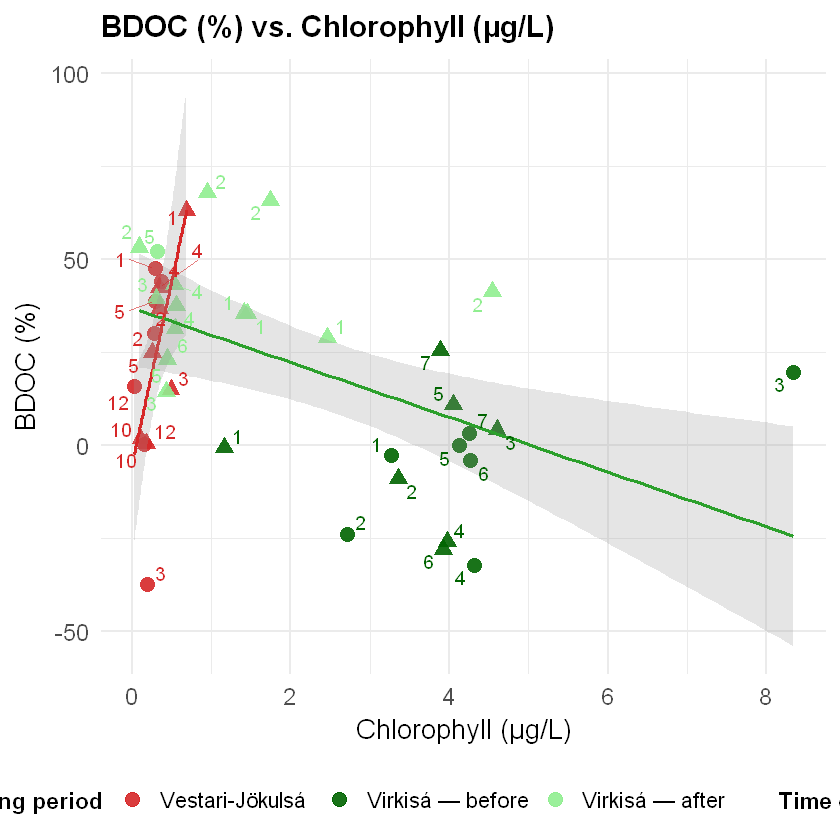

In [20]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden ====
raw <- readxl::read_excel(data_path)

dat <- raw %>%
  select(river_name, group_nr, day_time, site_nr,
         BDOC_pct, Chlorophyll_ugperL) %>%
  mutate(
    river_name = case_when(
      grepl("Vestari", river_name, ignore.case = TRUE) ~ "Vestari-Jökulsá",
      grepl("Virkis",  river_name, ignore.case = TRUE) ~ "Virkisá",
      TRUE ~ as.character(river_name)
    ),
    BDOC        = suppressWarnings(as.numeric(BDOC_pct)),
    Chlorophyll = suppressWarnings(as.numeric(Chlorophyll_ugperL)),
    period_cat  = case_when(
      river_name == "Virkisá" & group_nr == 1 ~ "Virkisá — before",
      river_name == "Virkisá" & group_nr != 1 ~ "Virkisá — after",
      river_name == "Vestari-Jökulsá"        ~ "Vestari-Jökulsá",
      TRUE ~ "other"
    )
  ) %>%
  filter(river_name %in% c("Vestari-Jökulsá","Virkisá"),
         is.finite(BDOC), is.finite(Chlorophyll))

stopifnot(nrow(dat) > 1)

# ==== Farben & Shapes ====
col_points <- c(
  "Vestari-Jökulsá"       = "#D62728",  # rot
  "Virkisá — before"      = "#006400",  # dunkelgrün
  "Virkisá — after"       = "#90EE90"   # hellgrün
)
shape_map <- c("VM" = 17, "NM" = 16)     # ▲ / ●

# ==== Linienfarben (eine Linie je River) ====
col_lines <- c("Vestari-Jökulsá" = "#D62728", "Virkisá" = "#2CA02C")

# ==== Plot ====
p <- ggplot(dat, aes(x = Chlorophyll, y = BDOC)) +
  # Punkte farbig nach River/Sampling-Periode
  geom_point(aes(colour = period_cat, shape = day_time), size = 3.8, alpha = 0.9) +
  # Regressionslinien: eine pro River
  geom_smooth(
    aes(group = river_name, colour = river_name),
    method = "lm", se = TRUE, linewidth = 1.0, alpha = 0.25, show.legend = FALSE
  ) +
  # Punktlabels (site_nr)
  ggrepel::geom_text_repel(
    aes(label = site_nr, colour = period_cat),
    size = 4.0, max.overlaps = 100,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6,
    show.legend = FALSE
  ) +
  scale_colour_manual(
    values = c(col_points, col_lines),
    breaks = names(col_points),
    name   = "River / Sampling period"
  ) +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  labs(
    title = "BDOC (%) vs. Chlorophyll (µg/L)",
    x = "Chlorophyll (µg/L)",
    y = "BDOC (%)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 10), size = 18),
    axis.title.x = element_text(size = 16, margin = margin(t = 6)),
    axis.title.y = element_text(size = 16, margin = margin(r = 6)),
    axis.text    = element_text(size = 14),
    legend.position = "bottom",
    legend.box = "horizontal",    # Legende nebeneinander
    legend.title = element_text(face = "bold", size = 14),
    legend.text  = element_text(size = 13)
  )

print(p)

# ==== Speichern (A4 quer, cm) ====
ggsave(file.path(out_dir, "Scatter_BDOC_vs_Chl_Vestari_Virkisa_labels_A4_landscape.png"),
       plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)


## phycocyanin

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


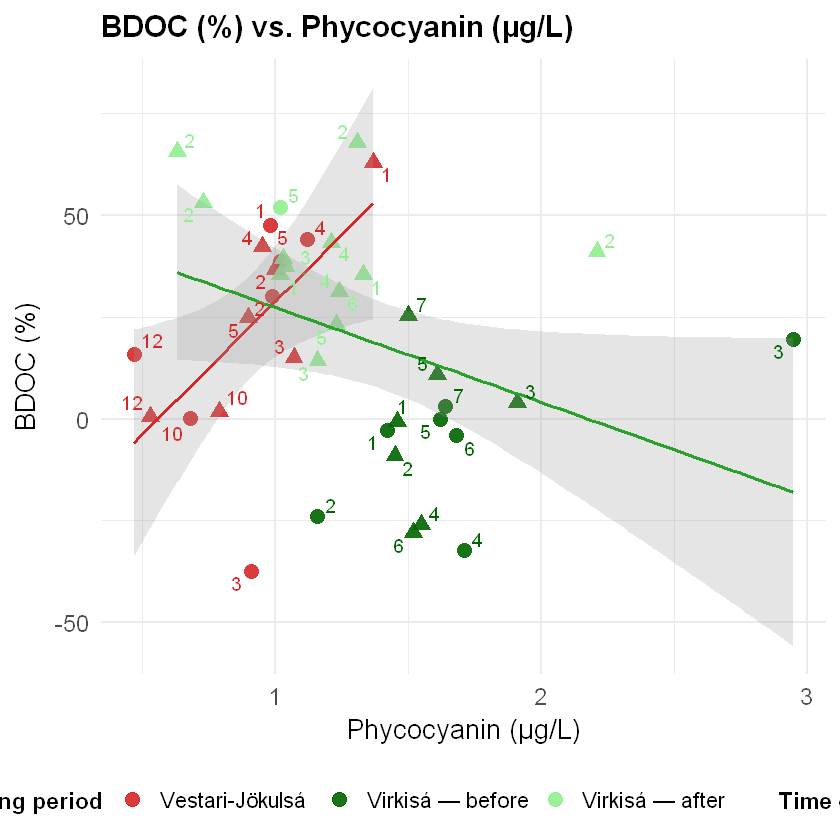

In [21]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2); library(ggrepel)
})

# ==== Pfade ====
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Scatterplots/"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Daten laden ====
raw <- readxl::read_excel(data_path)

dat <- raw %>%
  select(river_name, group_nr, day_time, site_nr,
         BDOC_pct, BGA_PC_ugperL) %>%                      # <-- Phycocyanin
  mutate(
    river_name = case_when(
      grepl("Vestari", river_name, ignore.case = TRUE) ~ "Vestari-Jökulsá",
      grepl("Virkis",  river_name, ignore.case = TRUE) ~ "Virkisá",
      TRUE ~ as.character(river_name)
    ),
    BDOC         = suppressWarnings(as.numeric(BDOC_pct)),
    Phycocyanin  = suppressWarnings(as.numeric(BGA_PC_ugperL)),   # <-- numerisch
    period_cat   = case_when(
      river_name == "Virkisá" & group_nr == 1 ~ "Virkisá — before",
      river_name == "Virkisá" & group_nr != 1 ~ "Virkisá — after",
      river_name == "Vestari-Jökulsá"        ~ "Vestari-Jökulsá",
      TRUE ~ "other"
    )
  ) %>%
  filter(river_name %in% c("Vestari-Jökulsá","Virkisá"),
         is.finite(BDOC), is.finite(Phycocyanin))

stopifnot(nrow(dat) > 1)

# ==== Farben & Shapes ====
col_points <- c(
  "Vestari-Jökulsá"       = "#D62728",  # rot
  "Virkisá — before"      = "#006400",  # dunkelgrün
  "Virkisá — after"       = "#90EE90"   # hellgrün
)
shape_map <- c("VM" = 17, "NM" = 16)     # ▲ / ●

# Linienfarben (eine Linie je River)
col_lines <- c("Vestari-Jökulsá" = "#D62728", "Virkisá" = "#2CA02C")

# ==== Plot ====
p <- ggplot(dat, aes(x = Phycocyanin, y = BDOC)) +
  # Punkte
  geom_point(aes(colour = period_cat, shape = day_time), size = 3.8, alpha = 0.9) +
  # Regressionslinien: eine pro River
  geom_smooth(
    aes(group = river_name, colour = river_name),
    method = "lm", se = TRUE, linewidth = 1.0, alpha = 0.25, show.legend = FALSE
  ) +
  # Punktlabels
  ggrepel::geom_text_repel(
    aes(label = site_nr, colour = period_cat),
    size = 4.0, max.overlaps = 100,
    box.padding = 0.25, point.padding = 0.2,
    segment.size = 0.2, segment.alpha = 0.6,
    show.legend = FALSE
  ) +
  scale_colour_manual(
    values = c(col_points, col_lines),
    breaks = names(col_points),
    name   = "River / Sampling period"
  ) +
  scale_shape_manual(values = shape_map, name = "Time of day") +
  labs(
    title = "BDOC (%) vs. Phycocyanin (µg/L)",
    x = "Phycocyanin (µg/L)",
    y = "BDOC (%)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title   = element_text(face = "bold", margin = margin(b = 10), size = 18),
    axis.title.x = element_text(size = 16, margin = margin(t = 6)),
    axis.title.y = element_text(size = 16, margin = margin(r = 6)),
    axis.text    = element_text(size = 14),
    legend.position = "bottom",
    legend.box = "horizontal",
    legend.title = element_text(face = "bold", size = 14),
    legend.text  = element_text(size = 13)
  )

print(p)

# ==== Speichern (A4 quer, cm) ====
ggsave(file.path(out_dir, "Scatter_BDOC_vs_Phycocyanin_Vestari_Virkisa_labels_A4_landscape.png"),
       plot = p, width = 29.7, height = 21.0, units = "cm", dpi = 300)


[1] "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Plots/DOC_vs_Distance_Virkisa.png"

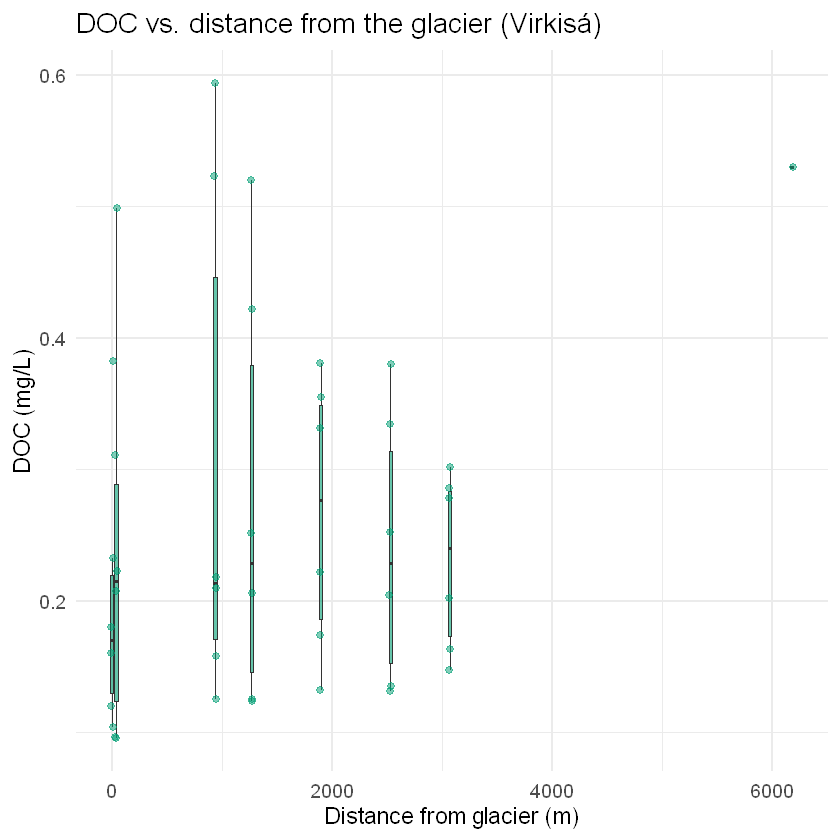

In [25]:
# 📦 Pakete
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2)
})

# ---- Pfade ----
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Plots"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
out_png   <- file.path(out_dir, "DOC_vs_Distance_Virkisa.png")

# ---- Farben (falls nicht vorhanden) ----
river_colors <- c("Virkisa"="#009E73", "Vestari_Joekulsa"="#D55E00")

# ---- Daten ----
raw <- readxl::read_excel(data_path)

df_vr <- raw %>%
  filter(grepl("^Virkis", river_name, ignore.case = TRUE)) %>%  # "Virkisa"/"Virkisá"
  transmute(
    river_name,
    site_nr,
    distance_from_glacier = as.numeric(distance_from_glacier),
    DOC_mgL = as.numeric(average_DOC_sample)
  ) %>%
  filter(!is.na(distance_from_glacier), !is.na(DOC_mgL))

stopifnot(nrow(df_vr) > 0)

# ---- Plot ----
p <- ggplot(df_vr, aes(distance_from_glacier, DOC_mgL)) +
  geom_boxplot(aes(group = site_nr, fill = river_name),
               alpha = 0.6, width = 30, outlier.shape = NA, show.legend = FALSE) +
  geom_jitter(aes(color = river_name),
              width = 10, alpha = 0.5, size = 1.8, show.legend = FALSE) +
  scale_fill_manual(values = river_colors) +
  scale_color_manual(values = river_colors) +
  labs(title = "DOC vs. distance from the glacier (Virkisá)",
       x = "Distance from glacier (m)", y = "DOC (mg/L)") +
  theme_minimal(base_size = 14)

print(p)

# ---- Speichern ----
ggsave(out_png, plot = p, width = 15, height = 12, units = "cm", dpi = 300)
out_png


[1] "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Plots/DOC_vs_Distance_Vestari.png"

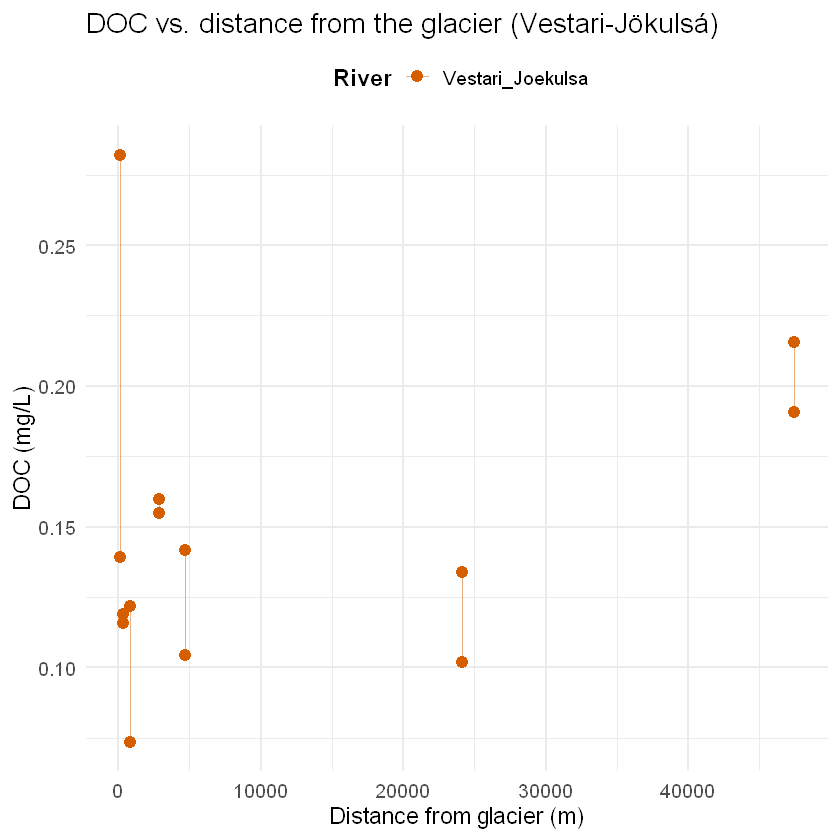

In [26]:
# 📦 Pakete
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(ggplot2)
})

# ---- Pfade ----
win_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
data_path <- if (file.exists(win_path)) win_path else "/mnt/data/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Plots"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
out_png   <- file.path(out_dir, "DOC_vs_Distance_Vestari.png")

# ---- Farben (falls nicht vorhanden) ----
river_colors <- c("Virkisa"="#009E73", "Vestari_Joekulsa"="#D55E00")

# ---- Daten ----
raw <- readxl::read_excel(data_path)

df_vj <- raw %>%
  filter(grepl("^Vestari", river_name, ignore.case = TRUE)) %>%  # Vestari_Joekulsa
  transmute(
    river_name,
    site_nr,
    distance_from_glacier = as.numeric(distance_from_glacier),
    DOC_mgL = as.numeric(average_DOC_sample)
  ) %>%
  filter(!is.na(distance_from_glacier), !is.na(DOC_mgL))

stopifnot(nrow(df_vj) > 0)

# ---- Plot ----
p <- ggplot(df_vj, aes(distance_from_glacier, DOC_mgL,
                       group = interaction(site_nr, river_name),
                       color = river_name)) +
  geom_line(alpha = 0.5) +
  geom_point(size = 3) +
  scale_color_manual(values = river_colors, name = "River") +
  labs(title = "DOC vs. distance from the glacier (Vestari-Jökulsá)",
       x = "Distance from glacier (m)", y = "DOC (mg/L)") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top",
        legend.title = element_text(face = "bold"))

print(p)

# ---- Speichern ----
ggsave(out_png, plot = p, width = 15, height = 12, units = "cm", dpi = 300)
out_png
